In [1]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [2]:
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import time
import pandas as pd
import pickle

from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2024-01-13 15:33:31.303668: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:33:31.384167: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:33:31.900541: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:33:31.903143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 15:33:32.862764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data Collection And Analysis

In [3]:
data_filepath = 'data/ohlcv_data.pkl'
if not os.path.exists(data_filepath):
    # fetch OHLCV (Open, High, Low, Close, Volume) data for BTC/EUR pair
    exchange = ccxt.binance()
    ohlcv = exchange.fetch_ohlcv('BTC/EUR', timeframe='1d')
    # save data for model tunning
    with open(data_filepath, 'wb') as file:
        pickle.dump(ohlcv, file)
    print('Data fetched and saved')
else:
    with open(data_filepath, 'rb') as file:
        ohlcv = pickle.load(file)
    print('Data loaded')

Data loaded


In [4]:
df_ohlcv = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

In [5]:
df_ohlcv['date'] = df_ohlcv['date'].apply(lambda x: datetime.fromtimestamp(x/1000))

In [6]:
df_ohlcv.head()

date      open      high       low     close      volume
0 2022-08-30 02:00:00  20293.72  20597.38  19529.83  19780.00  2688.27834
1 2022-08-31 02:00:00  19784.33  20450.00  19770.00  19989.56  2444.01828
2 2022-09-01 02:00:00  19987.89  20289.77  19697.00  20217.60  1996.51253
3 2022-09-02 02:00:00  20215.00  20428.41  19855.69  20072.48  2268.39539
4 2022-09-03 02:00:00  20064.95  20170.00  19771.71  19938.86   864.40522

In [7]:
df_ohlcv.describe()

date          open          high           low  \
count                         500    500.000000    500.000000    500.000000   
mean   2023-05-06 13:33:28.800000  24915.084140  25351.547760  24514.852360   
min           2022-08-30 02:00:00  15387.420000  15487.350000  15120.000000   
25%           2023-01-01 19:00:00  20261.507500  20577.672500  19800.387500   
50%           2023-05-06 14:00:00  24879.180000  25187.985000  24545.180000   
75%           2023-09-08 08:00:00  27062.100000  27395.042500  26744.475000   
max           2024-01-11 01:00:00  42945.190000  43952.000000  41642.000000   
std                           NaN   6348.125486   6481.886147   6218.709217   

              close        volume  
count    500.000000    500.000000  
mean   24958.709380   1607.491092  
min    15379.210000     88.261530  
25%    20262.250000    478.847445  
50%    24887.455000    981.268610  
75%    27071.780000   2307.970342  
max    42943.930000  11341.142750  
std     6391.539601   1620.007642

In [8]:
# filter the DataFrame to start at the specific date
df_ohlcv_year = df_ohlcv[df_ohlcv['date'] >= df_ohlcv['date'].max() - timedelta(days=365)]

In [9]:
df_ohlcv_year.describe()

date          open          high  \
count                            366    366.000000    366.000000   
mean   2023-07-12 13:35:34.426229248  27382.899180  27874.419153   
min              2023-01-11 01:00:00  16253.310000  16721.000000   
25%              2023-04-12 08:00:00  24274.385000  24709.140000   
50%              2023-07-12 14:00:00  25997.350000  26506.140000   
75%              2023-10-11 20:00:00  28070.375000  28444.332500   
max              2024-01-11 01:00:00  42945.190000  43952.000000   
std                              NaN   5540.776137   5648.724899   

                low         close       volume  
count    366.000000    366.000000   366.000000  
mean   26951.461257  27453.370738  1174.207842  
min    16100.000000  16672.660000    88.261530  
25%    23989.135000  24316.180000   393.602688  
50%    25558.310000  26015.475000   681.614705  
75%    27637.912500  28084.120000  1253.000530  
max    41642.000000  42943.930000  7990.789180  
std     5399.711661   5564.120889  1309.918652

In [10]:
df_year = df_ohlcv_year['open'].values

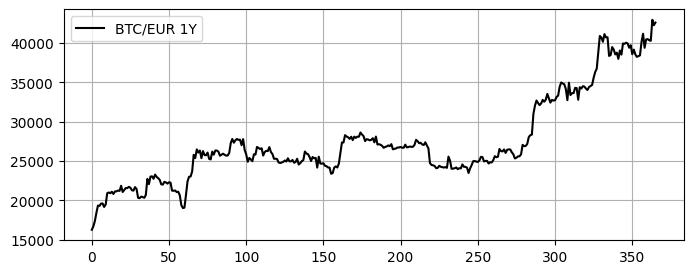

In [11]:
plt.figure(figsize=(8,3))
plt.plot(df_year, color='black', label='BTC/EUR 1Y')
plt.grid()
plt.legend();

# Data Preparation

In [12]:
df = df_ohlcv['open'].values
df = df.reshape(-1, 1)

In [13]:
# test train split
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

In [14]:
# scaling
scaler = MinMaxScaler()
dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_test_scaled = scaler.transform(dataset_test)

In [15]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    return np.array(x), np.array(y)

In [16]:
x_train, y_train = create_dataset(dataset_train_scaled)
x_test, y_test = create_dataset(dataset_test_scaled)

In [17]:
y_train.shape, y_test.shape

((350,), (100,))

In [18]:
x_train.shape, x_test.shape

((350, 50), (100, 50))

In [19]:
x_train[0]

array([0.37084992, 0.33234693, 0.34773331, 0.36489976, 0.35355801,
       0.34382322, 0.36113555, 0.342022  , 0.27345448, 0.29723021,
       0.2967714 , 0.4418294 , 0.46352499, 0.47359009, 0.50845737,
       0.36648254, 0.36917644, 0.33001962, 0.33342026, 0.35683695,
       0.3026286 , 0.31028777, 0.2688815 , 0.25707489, 0.32656305,
       0.33944828, 0.31157728, 0.3044336 , 0.34746347, 0.34022758,
       0.34860331, 0.34343547, 0.33548982, 0.32741038, 0.30902775,
       0.34577713, 0.37712889, 0.37419765, 0.37790063, 0.35284296,
       0.34463351, 0.34680435, 0.32619948, 0.32269378, 0.32854871,
       0.33656012, 0.3290506 , 0.32133322, 0.33152833, 0.33876573])

In [20]:
x_train[1]

array([0.33234693, 0.34773331, 0.36489976, 0.35355801, 0.34382322,
       0.36113555, 0.342022  , 0.27345448, 0.29723021, 0.2967714 ,
       0.4418294 , 0.46352499, 0.47359009, 0.50845737, 0.36648254,
       0.36917644, 0.33001962, 0.33342026, 0.35683695, 0.3026286 ,
       0.31028777, 0.2688815 , 0.25707489, 0.32656305, 0.33944828,
       0.31157728, 0.3044336 , 0.34746347, 0.34022758, 0.34860331,
       0.34343547, 0.33548982, 0.32741038, 0.30902775, 0.34577713,
       0.37712889, 0.37419765, 0.37790063, 0.35284296, 0.34463351,
       0.34680435, 0.32619948, 0.32269378, 0.32854871, 0.33656012,
       0.3290506 , 0.32133322, 0.33152833, 0.33876573, 0.31895754])

In [21]:
x_train[1][-1] == y_train[0]

True

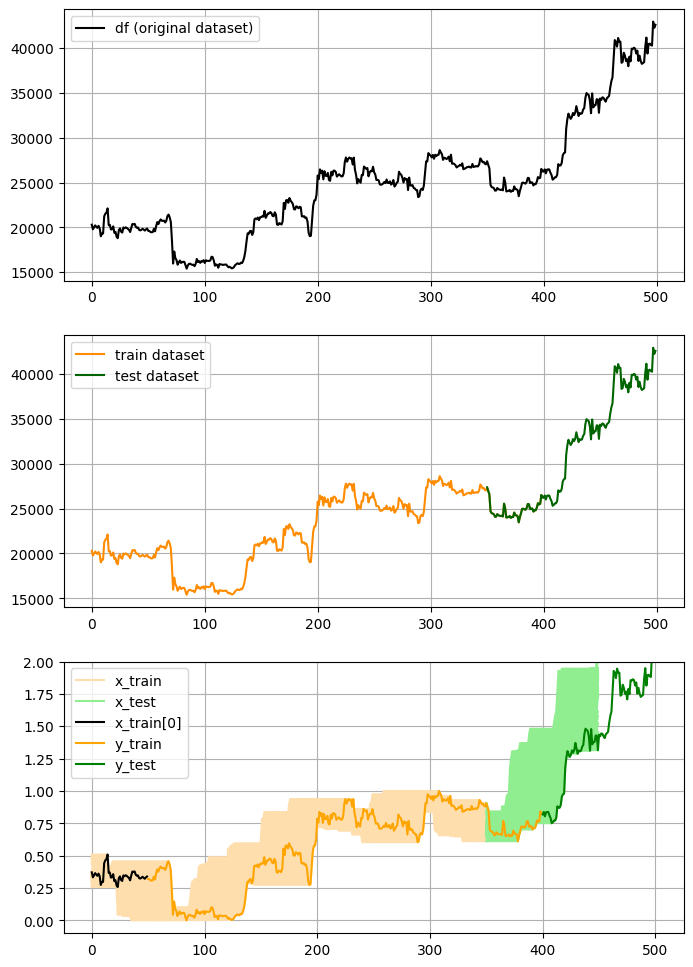

In [22]:
fig, ax = plt.subplots(figsize=(8, 12), nrows=3)
ax[0].plot(df, color='black', label='df (original dataset)')
ax[0].grid()
ax[0].legend();

ax[1].plot(dataset_train, color='darkorange', label='train dataset')
ax[1].plot(range(350, 500), dataset_test, color='darkgreen', label='test dataset')
ax[1].grid()
ax[1].legend();

ax[2].plot(x_train, color='navajowhite')
        
ax[2].plot(x_train[0], color='navajowhite', label='x_train')  # label
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+50), x_test[0], color='lightgreen', label='x_test')  # label
ax[2].plot(x_train[0], color='black', label='x_train[0]')
ax[2].plot(range(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), x_test, color='lightgreen')
ax[2].plot(range(50, y_train.shape[0]+50), y_train, color='orange', label='y_train')
ax[2].plot(range(y_train.shape[0]+50, y_train.shape[0]+y_test.shape[0]+50), y_test, color='green', label='y_test')
ax[2].set_xlim(-25, y_train.shape[0]+y_test.shape[0]+50+25)
ax[2].set_ylim(-0.1, 2)
ax[2].grid();
ax[2].legend();

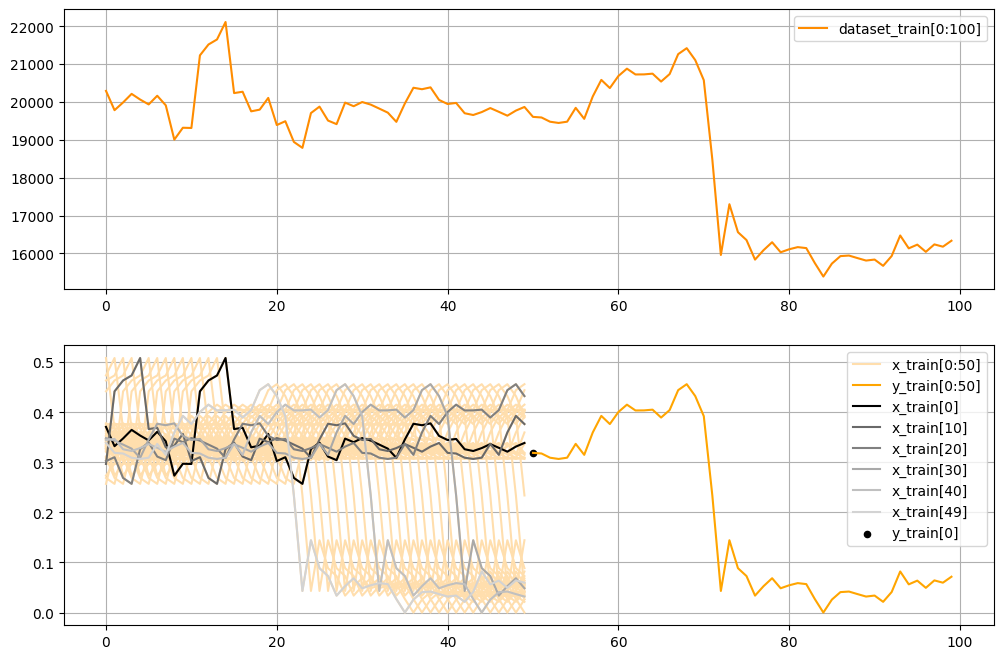

In [23]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_train[0], color='darkorange', label='dataset_train[0:100]')  # label
ax[0].plot(dataset_train[0:100], color='darkorange')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_train[0], color='navajowhite', label='x_train[0:50]')  # label
ax[1].plot(x_train[0:50], color='navajowhite')
ax[1].plot(range(50, 100), y_train[0:50], color='orange', label='y_train[0:50]')
ax[1].plot(x_train[0], color='black', label='x_train[0]')
ax[1].plot(x_train[10], color='dimgrey', label='x_train[10]')
ax[1].plot(x_train[20], color='grey', label='x_train[20]')
ax[1].plot(x_train[30], color='darkgrey', label='x_train[30]')
ax[1].plot(x_train[40], color='silver', label='x_train[40]')
ax[1].plot(x_train[49], color='lightgrey', label='x_train[49]')
ax[1].scatter(50, y_train[0], label='y_train[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

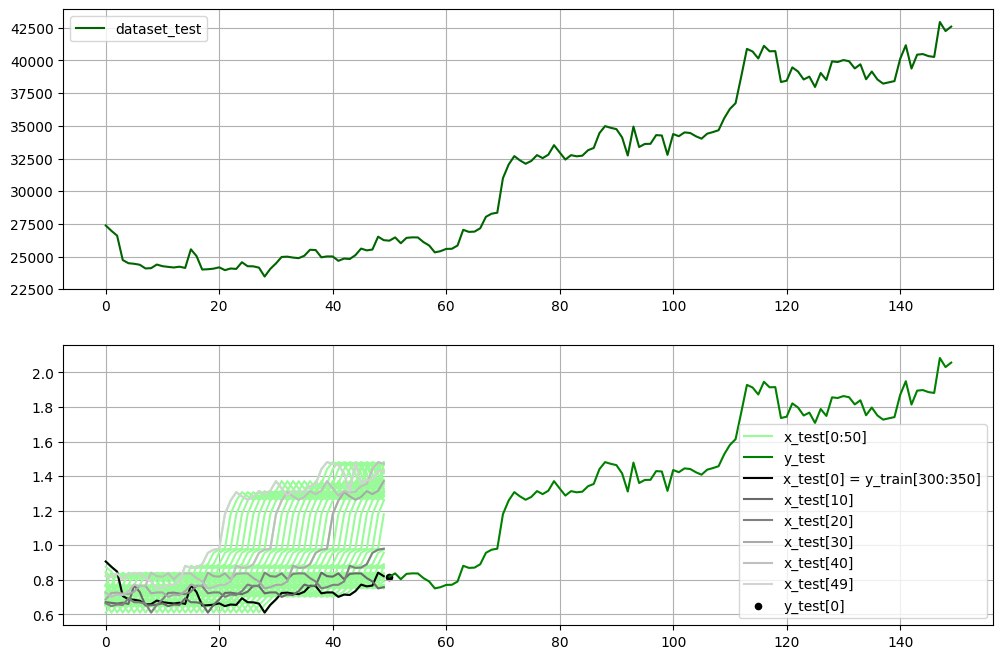

In [24]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2)

ax[0].plot(dataset_test[0], color='darkgreen', label='dataset_test')  # label
ax[0].plot(dataset_test, color='darkgreen')
ax[0].grid();
ax[0].legend();

ax[1].plot(x_test[0], color='palegreen', label='x_test[0:50]')  # label
ax[1].plot(x_test[0:50], color='palegreen')
ax[1].plot(range(50, 150), y_test, color='green', label='y_test')
ax[1].plot(x_test[0], color='black', label='x_test[0] = y_train[300:350]')
ax[1].plot(x_test[10], color='dimgrey', label='x_test[10]')
ax[1].plot(x_test[20], color='grey', label='x_test[20]')
ax[1].plot(x_test[30], color='darkgrey', label='x_test[30]')
ax[1].plot(x_test[40], color='silver', label='x_test[40]')
ax[1].plot(x_test[49], color='lightgrey', label='x_test[49]')
ax[1].scatter(50, y_test[0], label='y_test[0]', color='black', s=20)
ax[1].grid();
ax[1].legend();

In [25]:
# reshape data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(350, 50, 1)
(100, 50, 1)


# Baseline Model Creation, Training And Evaluation

In [26]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2024-01-13 15:33:37.485646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:33:37.486177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [28]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [29]:
if not os.path.exists('models/btc_eur_baseline.keras'):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('models/btc_eur_baseline.keras')

In [30]:
model = load_model('models/btc_eur_baseline.keras')

In [31]:
def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    return dict(mae=mae, mape=mape, r2=r2)

In [32]:
# make predictions (baseline)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
print('TEST SET:', get_metrics(y_test_inv, predictions))

4/4 [==============================] - 1s 26ms/step
TEST SET: {'mae': 1557.5742992187502, 'mape': 4.247253493580526, 'r2': 0.8565827360461834}


In [33]:
predictions_train = model.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
print('TRAIN SET:', get_metrics(y_train_inv, predictions_train))

11/11 [==============================] - 0s 18ms/step
TRAIN SET: {'mae': 486.6078662946428, 'mape': 2.2121259133715365, 'r2': 0.9667121425434528}


In [34]:
# make forecast (baseline)
future_steps = 30
forecast = []
input_data = x_test[-1]

for _ in range(future_steps):
    input_data = input_data.reshape((1, 50, 1))
    prediction = model.predict(input_data, verbose=0)
    forecast.append(prediction[0, 0])
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

forecast_inversed = scaler.inverse_transform(np.array(forecast).reshape((future_steps, 1)))

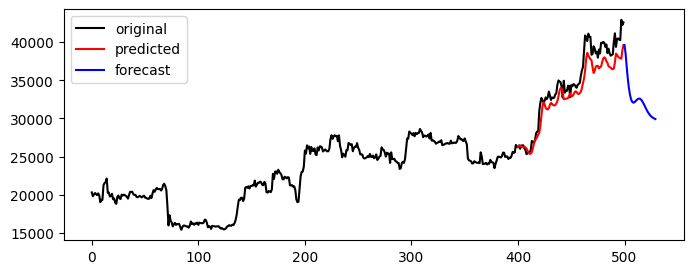

In [35]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(df, color='black', label='original')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='red', label='predicted')
plt.plot(range(len(df), len(df)+future_steps), forecast_inversed, color='blue', label='forecast')
plt.legend();

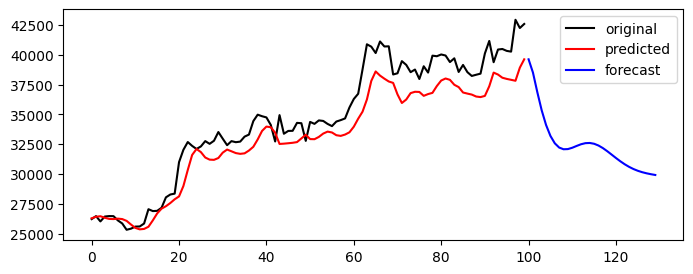

In [36]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(y_test_inv, color='black', label = 'original')
plt.plot(predictions, color = 'red', label='predicted')
plt.plot(range(100, 100+future_steps), forecast_inversed, color='blue', label='forecast')
plt.legend();

In [37]:
# below presentation is valid only for the newly fetched data; 
# otherwise dates and BTC/EUR values are not alligned since the last value from the dataset is treated as today's value
today = datetime.today()
next_day = today + timedelta(days=1)
one_week = today + timedelta(days=7)
one_month = today + timedelta(days=30)
today_value = df[-1][0]
next_day_forcasted_value = forecast_inversed[0][0]
one_week_forcasted_value = forecast_inversed[6][0]
one_month_forcasted_value = forecast_inversed[29][0]
change_value = np.abs(today_value - next_day_forcasted_value)
change_description = '-' if today_value > next_day_forcasted_value else '+'
message = f"""
BTC/EUR

TODAY      ({today.date()}): {today_value} EUR

FORECASTED ({next_day.date()}): {next_day_forcasted_value:.2f} EUR ({change_description}{change_value:.2f})
           ({one_week.date()}): {one_week_forcasted_value:.2f} EUR
           ({one_month.date()}): {one_month_forcasted_value:.2f} EUR
"""
print(message)


BTC/EUR

TODAY      (2024-01-13): 42593.8 EUR

FORECASTED (2024-01-14): 39626.19 EUR (-2967.61)
           (2024-01-20): 32576.36 EUR
           (2024-02-12): 29917.40 EUR



---

# Hyperparameter Tuning

In [38]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

class CustomKerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        units=96,
        activation='tanh',
        dropout_rate=0.2,
        recurrent_dropout=0.1,
        epochs=150, 
        batch_size=32, 
        validation_split=0.1,
        loss='mean_squared_error',
        learning_rate=0.0055,
        early_stopping=False,
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        hidden_lstm_layers=2
    ):
        self.units = units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.recurrent_dropout = recurrent_dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.loss = loss
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        self.monitor = monitor
        self.patience = monitor
        self.restore_best_weights = monitor
        self.hidden_lstm_layers = hidden_lstm_layers
        self.model = self._build_model()

    def fit(self, X, y):
        if not self.early_stopping:
            self.monitor = None
            self.patience = None
            self.restore_best_weights = None

        # set network parameters such as units, activation, recurrent_dropout, dropout_rate, and hidden_lstm_layers used in _build_model(), 
        # by RandomizedSearchCV in each iteration; otherwise default values from the __init__() method are used in all iterations
        state = self.__getstate__()
        self.__setstate__(state)
        
        callbacks = None
        if self.early_stopping:
            early_stopping_params = {param: self.__dict__[param] for param in ['monitor', 'patience', 'restore_best_weights'] if self.__dict__[param]}
            early_stopping = EarlyStopping(**early_stopping_params)
            callbacks = [early_stopping]

        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(loss=self.loss, optimizer=optimizer)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(X)

    def _build_model(self):
        model = Sequential()
        model.add(LSTM(units=self.units, activation=self.activation, recurrent_dropout=self.recurrent_dropout, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(Dropout(self.dropout_rate))
        
        # add hidden layers
        for i in range(1, self.hidden_lstm_layers+1):
            return_sequences=True
            if i == self.hidden_lstm_layers:
                return_sequences=False
            model.add(LSTM(units=self.units, activation=self.activation, recurrent_dropout=self.recurrent_dropout, return_sequences=return_sequences))
            model.add(Dropout(self.dropout_rate))
            
        model.add(Dense(units=1))
        return model

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['model']
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.model = self._build_model()

In [40]:
start_time = time.time()

In [41]:
f'Start time: {time.strftime("%H:%M")}'

'Start time: 15:33'

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from scipy.stats import uniform


keras_model = CustomKerasRegressor()

distributions = {
    'units': [64, 96, 128],  # [32, 64, 96, 128]
    'activation': [None, 'tanh', 'softsign'],  # [None, 'tanh', 'softsign']
    'dropout_rate': [0.1, 0.2, 0.3],  # [0.1, 0.2, 0.3]
    'recurrent_dropout': [0.0, 0.1, 0.2],  # [0.0, 0.1, 0.2]
    'epochs': [25, 50, 100, 150, 250, 400],  # [25, 50, 100, 150, 250, 400],
    'batch_size': [16, 32, 64, 128],  # [16, 32, 64, 128],
    'validation_split': [0.1],  # [0.1, 0.2]
    'learning_rate': uniform(loc=0.004, scale=0.002),  # uniform(loc=0.00001, scale=0.00999),
    'monitor': ['loss', 'val_loss'],  # ['loss', 'val_loss']
    'patience': [5, 10, 20, 30, 50],  # [5, 10, 15, 30],
    'restore_best_weights': [True, False],  # [True, False]
    'early_stopping': [False, True],  # [True, False]
    'hidden_lstm_layers': [1, 2, 3]  # [1, 2, 3]
}
optimizer = RandomizedSearchCV(
    keras_model,
    distributions,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=100,
    n_jobs=-1,
    pre_dispatch=4,
)
optimizer.fit(x_train, y_train)

2024-01-13 15:33:42.899849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:33:42.899849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:33:42.900995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:33:42.901243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:33:42.911759: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical re

Epoch 1/400
Epoch 1/400
Epoch 1/400
Epoch 1/400
7/7 [==============================] - 3s 154ms/step - loss: 0.1424 - val_loss: 0.0758
Epoch 2/400
7/7 [==============================] - 3s 160ms/step - loss: 0.1079 - val_loss: 0.0029
Epoch 2/400
7/7 [==============================] - 4s 163ms/step - loss: 0.2045 - val_loss: 0.0448
Epoch 2/400
7/7 [==============================] - 1s 111ms/step - loss: 0.0355 - val_loss: 0.0231
Epoch 3/400
7/7 [==============================] - 1s 114ms/step - loss: 0.0228 - val_loss: 0.0037
Epoch 3/400
7/7 [==============================] - 1s 113ms/step - loss: 0.0471 - val_loss: 0.0160
Epoch 3/400
7/7 [==============================] - 1s 88ms/step - loss: 0.0292 - val_loss: 0.0033
Epoch 4/400
7/7 [==============================] - 1s 88ms/step - loss: 0.0160 - val_loss: 0.0054
Epoch 4/400
7/7 [==============================] - 1s 96ms/step - loss: 0.0316 - val_loss: 0.0031
Epoch 4/400
7/7 [==============================] - 1s 91ms/step - loss: 0.01

2024-01-13 15:34:30.552395: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:34:30.554248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:34:30.596736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:34:30.597292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 100ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 63/400
7/7 [==============================] - 1s 100ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 63/400
7/7 [==============================] - 1s 176ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 31/400
4/7 [================>.............] - ETA: 0s - loss: 0.0056

2024-01-13 15:34:31.417682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 99ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 64/400
7/7 [==============================] - 1s 99ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 64/400
7/7 [==============================] - 1s 110ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 65/400
7/7 [==============================] - 1s 111ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 65/400
3/7 [===========>..................] - ETA: 0s - loss: 0.0035

2024-01-13 15:34:32.623431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:34:32.623738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 200ms/step - loss: 0.0088 - val_loss: 0.0018
Epoch 32/400
7/7 [==============================] - 1s 116ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 66/400
7/7 [==============================] - 1s 114ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 66/400
7/7 [==============================] - 1s 99ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 67/400
7/7 [==============================] - 1s 99ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 67/400
7/7 [==============================] - 1s 175ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 33/400
7/7 [==============================] - 1s 114ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 68/400
7/7 [==============================] - 1s 117ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 68/400
7/7 [==============================] - 1s 100ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 69/400
7/7 [==============================] - 1s 193ms/step - loss: 0.0080 - val_loss: 0.0045
Epoch 34/400
7/

2024-01-13 15:35:09.126275: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:35:09.129061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:35:09.172313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:35:09.173275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 102ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 113/400
7/7 [==============================] - 1s 210ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 56/400
7/7 [==============================] - 2s 222ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 17/400
7/7 [==============================] - 1s 136ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 114/400
3/7 [===========>..................] - ETA: 0s - loss: 0.0029

2024-01-13 15:35:10.367857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 107ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 115/400
7/7 [==============================] - 2s 224ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 57/400
7/7 [==============================] - 1s 217ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 18/400
7/7 [==============================] - 1s 107ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 116/400
4/7 [================>.............] - ETA: 0s - loss: 0.0046

2024-01-13 15:35:11.570419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:35:11.570750: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 117ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 117/400
7/7 [==============================] - 1s 212ms/step - loss: 0.0067 - val_loss: 0.0098
Epoch 19/400
7/7 [==============================] - 1s 210ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 59/400
7/7 [==============================] - 1s 197ms/step - loss: 0.0081 - val_loss: 0.0046
Epoch 20/400
6/7 [========================>.....] - ETA: 0s - loss: 0.0050

2024-01-13 15:35:14.904684: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:35:14.907105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:35:14.953785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:35:14.954680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 181ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 60/400
7/7 [==============================] - 1s 178ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 21/400
4/7 [================>.............] - ETA: 0s - loss: 0.0060

2024-01-13 15:35:15.832076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 176ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 61/400
7/7 [==============================] - 1s 176ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 22/400
3/7 [===========>..................] - ETA: 0s - loss: 0.0051

2024-01-13 15:35:16.956410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:35:16.956873: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 181ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 62/400
7/7 [==============================] - 1s 180ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 23/400
7/7 [==============================] - 1s 187ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 63/400
7/7 [==============================] - 1s 181ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 24/400
7/7 [==============================] - 1s 211ms/step - loss: 0.0071 - val_loss: 0.0016
Epoch 25/400
7/7 [==============================] - 2s 213ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 64/400
7/7 [==============================] - 1s 192ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 26/400
7/7 [==============================] - 1s 194ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 65/400
7/7 [==============================] - 1s 211ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 27/400
7/7 [==============================] - 1s 216ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 66/400


2024-01-13 15:36:25.887973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:36:25.890317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:36:25.936156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:36:25.936880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 2s 237ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 38/400
7/7 [==============================] - 2s 233ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 103/400
7/7 [==============================] - ETA: 0s - loss: 0.0046

2024-01-13 15:36:26.954921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 213ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 65/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 39/400
7/7 [==============================] - 2s 215ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 104/400
5/7 [====================>.........] - ETA: 0s - loss: 0.0038

2024-01-13 15:36:28.185058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:36:28.185604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 216ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 66/400
7/7 [==============================] - 1s 211ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 105/400
7/7 [==============================] - 1s 215ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 67/400
7/7 [==============================] - 1s 215ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 41/400
7/7 [==============================] - 1s 214ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 106/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 68/400
7/7 [==============================] - 1s 215ms/step - loss: 0.0052 - val_loss: 0.0070
Epoch 42/400
7/7 [==============================] - 1s 210ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 107/400
7/7 [==============================] - 1s 215ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 69/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 43/4

2024-01-13 15:37:37.043457: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:37:37.045887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:37:37.090621: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:37:37.091269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 2s 232ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 145/400
Epoch 81/400
6/7 [========================>.....] - ETA: 0s - loss: 0.0030

2024-01-13 15:37:38.209617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 2s 210ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 108/400
7/7 [==============================] - 1s 208ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 82/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0034 - val_loss: 8.9328e-04
Epoch 146/400
2/7 [=======>......................] - ETA: 0s - loss: 0.0033

2024-01-13 15:37:39.487928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:37:39.488766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 213ms/step - loss: 0.0035 - val_loss: 9.9434e-04
Epoch 109/400
7/7 [==============================] - 1s 214ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 83/400
7/7 [==============================] - 1s 211ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 147/400
7/7 [==============================] - 1s 211ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 110/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 84/400
7/7 [==============================] - 1s 212ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 148/400
7/7 [==============================] - 1s 213ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 111/400
7/7 [==============================] - 1s 215ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 85/400
7/7 [==============================] - 1s 214ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 149/400
7/7 [==============================] - 1s 212ms/step - loss: 0.0035 - val_loss: 9.7511e-04

2024-01-13 15:42:20.790248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:42:20.793171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:42:20.837033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:42:20.837516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 99ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 74/100
14/14 [==============================] - 1s 99ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 60/100
 6/14 [===========>..................] - ETA: 0s - loss: 0.0050

2024-01-13 15:42:21.782299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 203ms/step - loss: 0.0028 - val_loss: 8.6019e-04
Epoch 285/400
14/14 [==============================] - 1s 98ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 61/100


2024-01-13 15:42:23.005353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:42:23.006319: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 180ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 286/400
14/14 [==============================] - ETA: 0s - loss: 0.0042

2024-01-13 15:42:24.138828: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:42:24.140523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:42:24.186699: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:42:24.187401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 93ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 62/100
7/7 [==============================] - 1s 175ms/step - loss: 0.0027 - val_loss: 9.0798e-04
Epoch 287/400
 7/14 [==============>...............] - ETA: 0s - loss: 0.0052

2024-01-13 15:42:25.013283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 91ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 63/100
7/7 [==============================] - 1s 175ms/step - loss: 0.0021 - val_loss: 9.2000e-04
Epoch 288/400
 6/14 [===========>..................] - ETA: 0s - loss: 0.0104

2024-01-13 15:42:26.138662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:42:26.138956: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 93ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 64/100
7/7 [==============================] - 1s 173ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 289/400
14/14 [==============================] - 1s 93ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 65/100
7/7 [==============================] - 1s 169ms/step - loss: 0.0021 - val_loss: 8.8143e-04
Epoch 290/400
14/14 [==============================] - 1s 92ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 66/100
7/7 [==============================] - 1s 171ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 291/400
14/14 [==============================] - 1s 95ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 67/100
7/7 [==============================] - 1s 190ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 292/400
14/14 [==============================] - 1s 103ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 68/100
7/7 [==============================] - 1s 199ms/step - loss: 0.0025 - val_loss: 8.1726

2024-01-13 15:45:06.636892: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:06.638212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:06.662096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:06.662427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 2s 80ms/step - loss: 0.4596 - val_loss: 0.5912
Epoch 2/150
5/7 [====================>.........] - ETA: 0s - loss: 0.1302

2024-01-13 15:45:07.233915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 0s 45ms/step - loss: 0.1238 - val_loss: 0.5883
Epoch 3/150
7/7 [==============================] - 0s 47ms/step - loss: 0.0357 - val_loss: 0.5865
Epoch 4/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0151

2024-01-13 15:45:07.977866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:07.978105: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 0s 52ms/step - loss: 0.0156 - val_loss: 0.5828
Epoch 5/150
7/7 [==============================] - 0s 45ms/step - loss: 0.0122 - val_loss: 0.5776
Epoch 6/150
2/2 [==============================] - 3s 562ms/step - loss: 0.1681 - val_loss: 0.8991
Epoch 2/50
7/7 [==============================] - 0s 48ms/step - loss: 0.0108 - val_loss: 0.5768
Epoch 7/150
2/2 [==============================] - 0s 205ms/step - loss: 0.7721 - val_loss: 0.3171
Epoch 3/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0113 - val_loss: 0.5758
Epoch 8/150
2/2 [==============================] - 0s 182ms/step - loss: 0.1654 - val_loss: 0.3188
Epoch 4/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0103 - val_loss: 0.5762
Epoch 9/150
2/2 [==============================] - 0s 177ms/step - loss: 0.1433 - val_loss: 0.1799
Epoch 5/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0092 - val_loss: 0.5773
Epoch 10/150
2/2 [==============

2024-01-13 15:45:13.242840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:13.244117: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:13.271520: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:13.271845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 56ms/step - loss: 0.0088 - val_loss: 0.5972
Epoch 20/150
7/7 [==============================] - 0s 49ms/step - loss: 0.0072 - val_loss: 0.4532
Epoch 10/150
7/7 [==============================] - 0s 45ms/step - loss: 0.0069 - val_loss: 0.4538
Epoch 11/150
7/7 [==============================] - 0s 54ms/step - loss: 0.0078 - val_loss: 0.6001
Epoch 21/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0081

2024-01-13 15:45:13.885973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 0s 47ms/step - loss: 0.0070 - val_loss: 0.4550
Epoch 12/150
7/7 [==============================] - 0s 49ms/step - loss: 0.0092 - val_loss: 0.5995
Epoch 22/150
7/7 [==============================] - 0s 48ms/step - loss: 0.0072 - val_loss: 0.4577
Epoch 13/150
7/7 [==============================] - 0s 49ms/step - loss: 0.0091 - val_loss: 0.5996
Epoch 23/150
5/7 [====================>.........] - ETA: 0s - loss: 0.0084

2024-01-13 15:45:14.671813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:14.672072: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 0s 48ms/step - loss: 0.0082 - val_loss: 0.4572
Epoch 14/150
7/7 [==============================] - 0s 49ms/step - loss: 0.0086 - val_loss: 0.6004
Epoch 24/150
7/7 [==============================] - 0s 46ms/step - loss: 0.0070 - val_loss: 0.4569
Epoch 15/150
Epoch 1/150
7/7 [==============================] - 0s 48ms/step - loss: 0.0089 - val_loss: 0.5995
Epoch 25/150
7/7 [==============================] - 0s 46ms/step - loss: 0.0066 - val_loss: 0.4576
Epoch 16/150
7/7 [==============================] - 0s 50ms/step - loss: 0.0093 - val_loss: 0.6016
Epoch 26/150
7/7 [==============================] - 0s 45ms/step - loss: 0.0068 - val_loss: 0.4570
Epoch 17/150
7/7 [==============================] - 0s 50ms/step - loss: 0.0072 - val_loss: 0.6013
Epoch 27/150
7/7 [==============================] - 0s 46ms/step - loss: 0.0066 - val_loss: 0.4597
Epoch 18/150
7/7 [==============================] - 0s 46ms/step - loss: 0.0070 - val_loss: 0.4624
Epoch 19/15

2024-01-13 15:45:17.153580: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:17.155339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:17.182881: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:17.183227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 47ms/step - loss: 0.0060 - val_loss: 0.4695
Epoch 22/150
7/7 [==============================] - 0s 47ms/step - loss: 0.0182 - val_loss: 0.4095
Epoch 3/150
7/7 [==============================] - 0s 48ms/step - loss: 0.0055 - val_loss: 0.4717
Epoch 23/150
7/7 [==============================] - 0s 45ms/step - loss: 0.0095 - val_loss: 0.3950
Epoch 4/150
5/7 [====================>.........] - ETA: 0s - loss: 0.0068

2024-01-13 15:45:17.806510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 0s 44ms/step - loss: 0.0088 - val_loss: 0.3869
Epoch 5/150
7/7 [==============================] - 0s 46ms/step - loss: 0.0079 - val_loss: 0.3759
Epoch 6/150
3/7 [===========>..................] - ETA: 0s - loss: 0.0055

2024-01-13 15:45:18.555248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:18.555480: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 0s 41ms/step - loss: 0.0064 - val_loss: 0.3647
Epoch 7/150
7/7 [==============================] - ETA: 0s - loss: 0.0063

2024-01-13 15:45:18.922061: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:18.923465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:18.952017: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:18.952351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 47ms/step - loss: 0.0063 - val_loss: 0.3590
Epoch 8/150
7/7 [==============================] - 0s 41ms/step - loss: 0.0055 - val_loss: 0.3535
Epoch 9/150
3/7 [===========>..................] - ETA: 0s - loss: 0.0081

2024-01-13 15:45:19.494264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 0s 45ms/step - loss: 0.0053 - val_loss: 0.3468
Epoch 10/150
7/7 [==============================] - 0s 43ms/step - loss: 0.0049 - val_loss: 0.3402
Epoch 11/150
5/7 [====================>.........] - ETA: 0s - loss: 0.0052

2024-01-13 15:45:20.224417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:20.224748: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 0s 43ms/step - loss: 0.0050 - val_loss: 0.3392
Epoch 12/150
7/7 [==============================] - 0s 44ms/step - loss: 0.0053 - val_loss: 0.3418
Epoch 13/150
7/7 [==============================] - 0s 41ms/step - loss: 0.0045 - val_loss: 0.3413
Epoch 14/150
7/7 [==============================] - 0s 43ms/step - loss: 0.0049 - val_loss: 0.3245
Epoch 15/150
7/7 [==============================] - 0s 41ms/step - loss: 0.0052 - val_loss: 0.3113
Epoch 16/150
7/7 [==============================] - 0s 56ms/step - loss: 0.0052 - val_loss: 0.3068
Epoch 17/150
7/7 [==============================] - 0s 45ms/step - loss: 0.0042 - val_loss: 0.2998
Epoch 18/150
7/7 [==============================] - 0s 41ms/step - loss: 0.0042 - val_loss: 0.2868
Epoch 19/150
7/7 [==============================] - 0s 50ms/step - loss: 0.0053 - val_loss: 0.2898
Epoch 20/150
7/7 [==============================] - 0s 42ms/step - loss: 0.0050 - val_loss: 0.2815
Epoch 21/150
7/7 [=====

2024-01-13 15:45:34.808159: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:34.809907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:34.857087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:34.857784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 65ms/step - loss: 0.0029 - val_loss: 0.2479
Epoch 50/150
4/4 [==============================] - 1s 180ms/step - loss: 0.6445 - val_loss: 0.9621
Epoch 12/25
4/4 [==============================] - 1s 175ms/step - loss: 0.0224 - val_loss: 0.0044
Epoch 17/25
7/7 [==============================] - 0s 64ms/step - loss: 0.0031 - val_loss: 0.2391
Epoch 51/150
7/7 [==============================] - 0s 62ms/step - loss: 0.0032 - val_loss: 0.2340
Epoch 52/150
4/4 [==============================] - ETA: 0s - loss: 0.0242

2024-01-13 15:45:35.774638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 156ms/step - loss: 0.0242 - val_loss: 0.0032
Epoch 18/25
7/7 [==============================] - 0s 61ms/step - loss: 0.0028 - val_loss: 0.2228
Epoch 53/150
4/4 [==============================] - 1s 155ms/step - loss: 0.0222 - val_loss: 0.0038
Epoch 19/25
7/7 [==============================] - 0s 63ms/step - loss: 0.0032 - val_loss: 0.2195
Epoch 54/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0037

2024-01-13 15:45:36.813066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:36.813359: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 0s 59ms/step - loss: 0.0024 - val_loss: 0.2099
Epoch 55/150
4/4 [==============================] - 1s 151ms/step - loss: 0.0206 - val_loss: 0.0035
Epoch 20/25
3/7 [===========>..................] - ETA: 0s - loss: 0.0026

2024-01-13 15:45:37.275196: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 15:45:37.276841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:37.316558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 15:45:37.317029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 148ms/step - loss: 0.0188 - val_loss: 0.0032
Epoch 21/25
Epoch 1/25
3/4 [=====================>........] - ETA: 0s - loss: 0.0225

2024-01-13 15:45:38.083292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 140ms/step - loss: 0.0216 - val_loss: 0.0035
Epoch 22/25
4/4 [==============================] - 1s 140ms/step - loss: 0.0242 - val_loss: 0.0031
Epoch 23/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0226

2024-01-13 15:45:39.085160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 15:45:39.085525: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 142ms/step - loss: 0.0216 - val_loss: 0.0044
Epoch 24/25
4/4 [==============================] - 1s 137ms/step - loss: 0.0233 - val_loss: 0.0033
Epoch 25/25
4/4 [==============================] - 1s 32ms/step
Epoch 1/100
4/4 [==============================] - 7s 375ms/step - loss: 0.2452 - val_loss: 0.2346
Epoch 2/25
4/4 [==============================] - 1s 150ms/step - loss: 0.1115 - val_loss: 0.2887
Epoch 3/25
4/4 [==============================] - 1s 143ms/step - loss: 0.1292 - val_loss: 0.1104
Epoch 4/25
7/7 [==============================] - 7s 301ms/step - loss: 0.3273 - val_loss: 0.3488
Epoch 2/100
4/4 [==============================] - 1s 177ms/step - loss: 0.0848 - val_loss: 0.0836
Epoch 5/25
4/4 [==============================] - 1s 187ms/step - loss: 0.0649 - val_loss: 0.0957
Epoch 6/25
7/7 [==============================] - 2s 223ms/step - loss: 0.1554 - val_loss: 0.0242
Epoch 3/100
4/4 [==============================] - 1s 155ms/st

2024-01-13 16:05:24.565347: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:05:24.613062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.


7/7 [==============================] - 0s 66ms/step - loss: 0.0023 - val_loss: 9.6123e-04
Epoch 155/400
7/7 [==============================] - 0s 65ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 105/400
1/7 [===>..........................] - ETA: 0s - loss: 0.0027

2024-01-13 16:05:25.069281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:05:25.070937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 67ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 156/400
7/7 [==============================] - 0s 68ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 106/400
7/7 [==============================] - 0s 68ms/step - loss: 0.0029 - val_loss: 9.5870e-04
Epoch 157/400
7/7 [==============================] - 0s 68ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 107/400
7/7 [==============================] - ETA: 0s - loss: 0.0025

2024-01-13 16:05:26.417182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 0s 69ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 158/400
7/7 [==============================] - 0s 68ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 108/400
7/7 [==============================] - 0s 66ms/step - loss: 0.0027 - val_loss: 8.2109e-04
Epoch 159/400
7/7 [==============================] - 0s 68ms/step - loss: 0.0023 - val_loss: 8.8975e-04
Epoch 109/400
7/7 [==============================] - 0s 67ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 160/400
7/7 [==============================] - 0s 65ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 110/400
7/7 [==============================] - 0s 72ms/step - loss: 0.0028 - val_loss: 8.2170e-04
Epoch 161/400
7/7 [==============================] - 0s 72ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 111/400
7/7 [==============================] - 0s 66ms/step - loss: 0.0030 - val_loss: 9.0009e-04
Epoch 162/400
4/4 [==============================] - 4s 207ms/step - loss: 1.6284 - val_loss: 0.12

2024-01-13 16:05:28.963465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:05:28.964769: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 96ms/step - loss: 0.0027 - val_loss: 8.3806e-04
Epoch 163/400
7/7 [==============================] - 1s 97ms/step - loss: 0.0021 - val_loss: 9.5411e-04
Epoch 113/400
4/4 [==============================] - 0s 82ms/step - loss: 0.2146 - val_loss: 0.0102
Epoch 4/250
4/4 [==============================] - 0s 97ms/step - loss: 0.0479 - val_loss: 0.0155
Epoch 5/250
7/7 [==============================] - 1s 91ms/step - loss: 0.0027 - val_loss: 9.7350e-04
Epoch 164/400
7/7 [==============================] - 1s 92ms/step - loss: 0.0019 - val_loss: 8.2006e-04
Epoch 114/400
4/4 [==============================] - 0s 107ms/step - loss: 0.0231 - val_loss: 0.0018
Epoch 6/250
7/7 [==============================] - 1s 97ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 165/400
4/4 [==============================] - 0s 80ms/step - loss: 0.0222 - val_loss: 0.0020
Epoch 7/250
7/7 [==============================] - 1s 97ms/step - loss: 0.0018 - val_loss: 9.5052e-04
E

2024-01-13 16:07:25.483893: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:07:25.486377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:25.529151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:25.529819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 138ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 82/100
4/4 [==============================] - 0s 82ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 201/250
4/4 [==============================] - 0s 81ms/step - loss: 0.0030 - val_loss: 8.7318e-04
Epoch 235/250
2/2 [==============================] - 0s 145ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 83/100
4/4 [==============================] - 0s 82ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 202/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 236/250
2/2 [==============================] - 0s 140ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 84/100
2/2 [==============================] - 0s 136ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 85/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 237/250
2/4 [==============>...............] - ETA: 0s - loss: 0.0027

2024-01-13 16:07:26.353773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 139ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 86/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 204/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0029 - val_loss: 8.7557e-04
Epoch 238/250
2/2 [==============================] - 0s 144ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 87/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 205/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 239/250
2/2 [==============================] - 0s 146ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 88/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 206/250
4/4 [==============================] - 0s 83ms/step - loss: 0.0030 - val_loss: 8.5410e-04
Epoch 240/250
2/2 [==============================] - 0s 152ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch

2024-01-13 16:07:27.450038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:07:27.450373: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 87ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 207/250
4/4 [==============================] - 0s 87ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 241/250
2/2 [==============================] - 0s 147ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 90/100
4/4 [==============================] - 0s 87ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 208/250
4/4 [==============================] - 0s 82ms/step - loss: 0.0032 - val_loss: 8.5828e-04
Epoch 242/250
2/2 [==============================] - 0s 139ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 91/100
2/2 [==============================] - 0s 143ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 92/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 209/250
4/4 [==============================] - 0s 78ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 243/250
2/2 [==============================] - 0s 146ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 93/

2024-01-13 16:07:31.876358: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:07:31.878009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:31.912058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:31.912456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 68ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 221/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 222/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 223/250
4/4 [==============================] - 0s 68ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 224/250
10/14 [====================>.........] - ETA: 0s - loss: 0.2120

2024-01-13 16:07:32.644451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 66ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 225/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 226/250
14/14 [==============================] - 5s 84ms/step - loss: 0.1713 - val_loss: 0.0199
Epoch 2/25
4/4 [==============================] - 0s 71ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 227/250
 6/14 [===========>..................] - ETA: 0s - loss: 0.0243

2024-01-13 16:07:33.563027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:07:33.563402: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 69ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 228/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 229/250
14/14 [==============================] - 1s 63ms/step - loss: 0.0265 - val_loss: 0.0104
Epoch 3/25
4/4 [==============================] - 0s 73ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 230/250
4/4 [==============================] - 0s 67ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 231/250
4/4 [==============================] - 0s 70ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 232/250
14/14 [==============================] - 1s 61ms/step - loss: 0.0245 - val_loss: 0.0025
Epoch 4/25
4/4 [==============================] - 0s 69ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 233/250
4/4 [==============================] - 0s 74ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 234/250
4/4 [==============================] - 0s 77ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 235/250
14

2024-01-13 16:07:41.207881: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:07:41.209814: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:41.240950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:07:41.241362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 62ms/step - loss: 0.0142 - val_loss: 0.0015
Epoch 5/25
14/14 [==============================] - 1s 62ms/step - loss: 0.0143 - val_loss: 0.0024
Epoch 12/25


2024-01-13 16:07:41.971088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 68ms/step - loss: 0.0128 - val_loss: 0.0020
Epoch 6/25
14/14 [==============================] - 1s 67ms/step - loss: 0.0144 - val_loss: 0.0026
Epoch 13/25
 4/14 [=======>......................] - ETA: 0s - loss: 0.0089

2024-01-13 16:07:43.079803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:07:43.080443: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 65ms/step - loss: 0.0119 - val_loss: 0.0034
Epoch 7/25
14/14 [==============================] - 1s 64ms/step - loss: 0.0117 - val_loss: 0.0016
Epoch 14/25
Epoch 1/25
14/14 [==============================] - 1s 63ms/step - loss: 0.0111 - val_loss: 0.0014
Epoch 8/25
14/14 [==============================] - 1s 62ms/step - loss: 0.0110 - val_loss: 0.0021
Epoch 15/25
14/14 [==============================] - 1s 62ms/step - loss: 0.0105 - val_loss: 0.0014
Epoch 9/25
14/14 [==============================] - 1s 61ms/step - loss: 0.0123 - val_loss: 0.0035
Epoch 16/25
14/14 [==============================] - 1s 61ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 10/25
14/14 [==============================] - 1s 62ms/step - loss: 0.0141 - val_loss: 0.0018
Epoch 17/25
14/14 [==============================] - 1s 61ms/step - loss: 0.0108 - val_loss: 0.0015
Epoch 18/25
14/14 [==============================] - 1s 65ms/step - loss: 0.0110 - val_loss: 0.0022
Epoc

2024-01-13 16:17:07.255308: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:07.257772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:07.291995: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:07.292497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 37ms/step


2024-01-13 16:17:07.980466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-13 16:17:08.263504: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:08.265071: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:08.291734: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:08.292082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compi

Epoch 1/25


2024-01-13 16:17:09.458177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:09.458432: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-13 16:17:09.648985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:09.649273: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make

Epoch 1/25
Epoch 1/50
4/4 [==============================] - 4s 252ms/step - loss: 0.3017 - val_loss: 0.1611
Epoch 2/25
4/4 [==============================] - 0s 105ms/step - loss: 0.1268 - val_loss: 0.1085
Epoch 3/25
4/4 [==============================] - 0s 110ms/step - loss: 0.0514 - val_loss: 0.0114
Epoch 4/25
4/4 [==============================] - 5s 314ms/step - loss: 0.3590 - val_loss: 0.1867
Epoch 2/25
4/4 [==============================] - 0s 103ms/step - loss: 0.0358 - val_loss: 0.0377
Epoch 5/25
1/4 [======>.......................] - ETA: 0s - loss: 0.1128

2024-01-13 16:17:14.700285: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:14.702732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:14.755097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:14.755580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 102ms/step - loss: 0.0296 - val_loss: 0.0039
Epoch 6/25
4/4 [==============================] - 0s 108ms/step - loss: 0.1379 - val_loss: 0.2908
Epoch 3/25
4/4 [==============================] - 0s 103ms/step - loss: 0.0192 - val_loss: 0.0090
Epoch 4/25
Epoch 7/25
2/4 [==============>...............] - ETA: 0s - loss: 0.0165

2024-01-13 16:17:15.599203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 105ms/step - loss: 0.0565 - val_loss: 0.0053
Epoch 5/25
4/4 [==============================] - 0s 107ms/step - loss: 0.0167 - val_loss: 0.0140
Epoch 8/25
4/4 [==============================] - 0s 100ms/step - loss: 0.0339 - val_loss: 0.0559
Epoch 6/25
4/4 [==============================] - 0s 101ms/step - loss: 0.0235 - val_loss: 0.0093
Epoch 9/25
4/4 [==============================] - ETA: 0s - loss: 0.0341

2024-01-13 16:17:16.655779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:16.656453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 108ms/step - loss: 0.0152 - val_loss: 0.0046
Epoch 10/25
4/4 [==============================] - 0s 122ms/step - loss: 0.0341 - val_loss: 0.0066
Epoch 7/25
4/4 [==============================] - 0s 108ms/step - loss: 0.0209 - val_loss: 0.0168
Epoch 8/25
4/4 [==============================] - 0s 121ms/step - loss: 0.0157 - val_loss: 0.0060
Epoch 11/25
4/4 [==============================] - 0s 104ms/step - loss: 0.0202 - val_loss: 0.0036
Epoch 9/25
4/4 [==============================] - 0s 114ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 12/25
4/4 [==============================] - 0s 121ms/step - loss: 0.0207 - val_loss: 0.0068
Epoch 10/25
4/4 [==============================] - 0s 112ms/step - loss: 0.0126 - val_loss: 0.0016
Epoch 13/25
4/4 [==============================] - 0s 104ms/step - loss: 0.0170 - val_loss: 0.0099
Epoch 11/25
4/4 [==============================] - 0s 106ms/step - loss: 0.0113 - val_loss: 0.0033
Epoch 14/25
4/4 [========

2024-01-13 16:17:25.440226: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:25.441923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:25.474699: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:25.475164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11/14 [======================>.......] - ETA: 0s - loss: 0.0197

2024-01-13 16:17:26.216863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 2/14 [===>..........................] - ETA: 1s - loss: 0.1772  

2024-01-13 16:17:26.512492: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:26.514703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:26.561818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:26.562381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 122ms/step - loss: 0.0200 - val_loss: 0.0026
Epoch 6/50
 6/14 [===========>..................] - ETA: 0s - loss: 0.0203

2024-01-13 16:17:27.308201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:27.308693: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-13 16:17:27.393701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 121ms/step - loss: 0.0184 - val_loss: 0.0048
Epoch 7/50
Epoch 1/50


2024-01-13 16:17:28.374867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:28.375114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 11s 175ms/step - loss: 0.1224 - val_loss: 0.0024
Epoch 2/50
14/14 [==============================] - 2s 125ms/step - loss: 0.0192 - val_loss: 0.0079
Epoch 8/50
14/14 [==============================] - 2s 122ms/step - loss: 0.0224 - val_loss: 0.1465
Epoch 3/50
14/14 [==============================] - 2s 124ms/step - loss: 0.0191 - val_loss: 0.0022
Epoch 9/50
14/14 [==============================] - 2s 123ms/step - loss: 0.0436 - val_loss: 0.0025
Epoch 4/50
14/14 [==============================] - 2s 129ms/step - loss: 0.0177 - val_loss: 0.0032
Epoch 10/50
14/14 [==============================] - 2s 130ms/step - loss: 0.0263 - val_loss: 0.0028
Epoch 5/50
14/14 [==============================] - 2s 124ms/step - loss: 0.0151 - val_loss: 0.0029
Epoch 11/50
14/14 [==============================] - 2s 125ms/step - loss: 0.0251 - val_loss: 0.0018
Epoch 6/50
14/14 [==============================] - 2s 132ms/step - loss: 0.0117 - val_loss: 0.0040
Epoch 12

2024-01-13 16:17:43.530823: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:17:43.532837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:43.571182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:17:43.571797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 140ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 10/50
14/14 [==============================] - 2s 139ms/step - loss: 0.0270 - val_loss: 0.0014
Epoch 4/50
 8/14 [================>.............] - ETA: 0s - loss: 0.0072

2024-01-13 16:17:44.622515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 106ms/step - loss: 0.0105 - val_loss: 0.0016
Epoch 7/50
14/14 [==============================] - 2s 138ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 11/50
14/14 [==============================] - 2s 141ms/step - loss: 0.0184 - val_loss: 0.0016
Epoch 5/50
 9/14 [==================>...........] - ETA: 0s - loss: 0.0097

2024-01-13 16:17:45.822237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:17:45.822720: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 99ms/step - loss: 0.0102 - val_loss: 0.0026
Epoch 8/50
14/14 [==============================] - 2s 134ms/step - loss: 0.0081 - val_loss: 0.0020
Epoch 12/50
14/14 [==============================] - 2s 133ms/step - loss: 0.0163 - val_loss: 0.0036
Epoch 6/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0103 - val_loss: 0.0016
Epoch 9/50
14/14 [==============================] - 1s 99ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 10/50
14/14 [==============================] - 2s 131ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 13/50
14/14 [==============================] - 2s 130ms/step - loss: 0.0139 - val_loss: 0.0163
Epoch 7/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 11/50
14/14 [==============================] - 2s 128ms/step - loss: 0.0135 - val_loss: 0.0034
Epoch 8/50
14/14 [==============================] - 2s 131ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 14/50

2024-01-13 16:18:05.284684: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:18:05.287567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:05.332638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:05.333322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 101ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 21/50
14/14 [==============================] - 1s 105ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 8/50
 8/14 [================>.............] - ETA: 0s - loss: 0.0071

2024-01-13 16:18:06.284833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 138ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 22/50
14/14 [==============================] - 1s 104ms/step - loss: 0.0167 - val_loss: 0.0023
Epoch 9/50
 5/14 [=========>....................] - ETA: 1s - loss: 0.0064

2024-01-13 16:18:07.604821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:18:07.605880: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 100ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 23/50
14/14 [==============================] - 2s 137ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 23/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0161 - val_loss: 0.0048
Epoch 10/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 24/50
14/14 [==============================] - 1s 103ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 11/50
14/14 [==============================] - 2s 133ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 24/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 25/50
14/14 [==============================] - 1s 104ms/step - loss: 0.0183 - val_loss: 0.0212
Epoch 12/50
14/14 [==============================] - 1s 100ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 26/50
14/14 [==============================] - 2s 133ms/step - loss: 0.0057 - val_loss: 0.0047
Ep

2024-01-13 16:18:48.353883: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:18:48.356592: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:48.398650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:48.399218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 105ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 21/50
14/14 [==============================] - 1s 103ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 35/50
 4/14 [=======>......................] - ETA: 0s - loss: 0.0037

2024-01-13 16:18:49.326143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 101ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 50/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 22/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 36/50
 1/14 [=>............................] - ETA: 1s - loss: 0.0068

2024-01-13 16:18:50.576701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:18:50.577165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 99ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 23/50
14/14 [==============================] - 1s 100ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 37/50
13/14 [==========================>...] - ETA: 0s - loss: 0.0060

2024-01-13 16:18:52.786717: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:18:52.789670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:52.829302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:18:52.829822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 93ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 24/50
14/14 [==============================] - 1s 95ms/step - loss: 0.0032 - val_loss: 9.6476e-04
Epoch 38/50
 7/14 [==============>...............] - ETA: 0s - loss: 0.0028

2024-01-13 16:18:53.669984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 95ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 25/50
14/14 [==============================] - 1s 94ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 39/50
 3/14 [=====>........................] - ETA: 1s - loss: 0.0024    

2024-01-13 16:18:54.759071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:18:54.759564: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 94ms/step - loss: 0.0041 - val_loss: 0.0067
Epoch 26/50
Epoch 1/25
14/14 [==============================] - 1s 96ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 40/50
14/14 [==============================] - 1s 93ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 27/50
14/14 [==============================] - 1s 94ms/step - loss: 0.0029 - val_loss: 9.2937e-04
Epoch 41/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 28/50
14/14 [==============================] - 1s 96ms/step - loss: 0.0032 - val_loss: 9.9467e-04
Epoch 42/50
4/4 [==============================] - 7s 329ms/step - loss: 0.2890 - val_loss: 0.0543
Epoch 2/25
4/4 [==============================] - 0s 112ms/step - loss: 0.0472 - val_loss: 0.0302
Epoch 3/25
14/14 [==============================] - 1s 99ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 29/50
4/4 [==============================] - 0s 116ms/step - loss: 0.0421 - val_loss: 0.012

2024-01-13 16:29:10.053190: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:29:10.055128: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:29:10.097459: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:29:10.097969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 128ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 155/400
 1/14 [=>............................] - ETA: 1s - loss: 0.0033

2024-01-13 16:29:11.014029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 129ms/step - loss: 0.0073 - val_loss: 0.0010
Epoch 134/400
 3/14 [=====>........................] - ETA: 1s - loss: 0.0036

2024-01-13 16:29:12.141125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:29:12.141394: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 122ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 156/400
14/14 [==============================] - 2s 128ms/step - loss: 0.0049 - val_loss: 0.0010
Epoch 135/400
14/14 [==============================] - 2s 124ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 157/400
14/14 [==============================] - 2s 133ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 136/400
14/14 [==============================] - 2s 132ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 158/400
14/14 [==============================] - 2s 135ms/step - loss: 0.0055 - val_loss: 8.6122e-04
Epoch 137/400
14/14 [==============================] - 12s 202ms/step - loss: 0.7257 - val_loss: 0.0324
Epoch 2/400
14/14 [==============================] - 2s 130ms/step - loss: 0.0030 - val_loss: 8.6915e-04
Epoch 159/400
14/14 [==============================] - 2s 139ms/step - loss: 0.0049 - val_loss: 9.0190e-04
Epoch 138/400
14/14 [==============================] - 2s 138ms/step - loss:

2024-01-13 16:30:40.113450: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:30:40.117594: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:30:40.159952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:30:40.160558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 141ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 177/400
14/14 [==============================] - 2s 141ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 43/400
14/14 [==============================] - 2s 133ms/step - loss: 0.0024 - val_loss: 8.4906e-04
Epoch 201/400
 3/14 [=====>........................] - ETA: 1s - loss: 0.0029

2024-01-13 16:30:41.090573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 145ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 178/400
 1/14 [=>............................] - ETA: 2s - loss: 0.0049

2024-01-13 16:30:42.361085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:30:42.362245: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 137ms/step - loss: 0.0096 - val_loss: 0.0025
Epoch 44/400
14/14 [==============================] - 2s 134ms/step - loss: 0.0029 - val_loss: 8.3002e-04
Epoch 202/400
14/14 [==============================] - 2s 139ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 179/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0075 - val_loss: 0.0134
Epoch 45/400
14/14 [==============================] - 2s 133ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 203/400
14/14 [==============================] - 2s 137ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 180/400
14/14 [==============================] - 2s 136ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 46/400
14/14 [==============================] - 2s 132ms/step - loss: 0.0033 - val_loss: 8.3755e-04
Epoch 204/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 181/400
14/14 [==============================] - 2s 132ms/step - loss: 0.003

2024-01-13 16:31:42.558874: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:31:42.561342: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:31:42.605354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:31:42.605884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 8/14 [================>.............] - ETA: 0s - loss: 0.0037

2024-01-13 16:31:43.582116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 138ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 75/400
14/14 [==============================] - 2s 134ms/step - loss: 0.0030 - val_loss: 9.9038e-04
Epoch 234/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 209/400
 2/14 [===>..........................] - ETA: 1s - loss: 0.0050

2024-01-13 16:31:44.803395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:31:44.804399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 137ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 76/400
14/14 [==============================] - 2s 137ms/step - loss: 0.0030 - val_loss: 9.0392e-04
Epoch 235/400
14/14 [==============================] - 2s 140ms/step - loss: 0.0044 - val_loss: 0.0109
Epoch 210/400
14/14 [==============================] - 2s 135ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 77/400
14/14 [==============================] - 2s 141ms/step - loss: 0.0035 - val_loss: 9.4538e-04
Epoch 236/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 211/400
14/14 [==============================] - 2s 135ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 78/400
14/14 [==============================] - 2s 134ms/step - loss: 0.0034 - val_loss: 8.1595e-04
Epoch 237/400
14/14 [==============================] - 2s 141ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 212/400
14/14 [==============================] - 2s 134ms/step - loss: 0

2024-01-13 16:33:59.968776: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:33:59.970743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:34:00.014535: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:34:00.015028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 135ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 297/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 136/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0035

2024-01-13 16:34:00.964761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 139ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 269/400
14/14 [==============================] - 2s 131ms/step - loss: 0.0033 - val_loss: 8.9497e-04
Epoch 298/400
14/14 [==============================] - 2s 137ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 137/400
 8/14 [================>.............] - ETA: 0s - loss: 0.0035

2024-01-13 16:34:02.163732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:34:02.164680: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 141ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 270/400
14/14 [==============================] - 2s 134ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 299/400
14/14 [==============================] - 2s 140ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 138/400
14/14 [==============================] - 2s 144ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 271/400
14/14 [==============================] - 2s 135ms/step - loss: 0.0029 - val_loss: 8.9564e-04
Epoch 300/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 139/400
14/14 [==============================] - 2s 141ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 272/400
14/14 [==============================] - 2s 134ms/step - loss: 0.0022 - val_loss: 9.9998e-04
Epoch 301/400
14/14 [==============================] - 2s 138ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 140/400
14/14 [==============================] - 2s 143ms/step - loss: 0.

2024-01-13 16:38:19.577046: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:38:19.580144: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:19.631503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:19.632793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 172ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 144/150
14/14 [==============================] - 2s 145ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 384/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0054

2024-01-13 16:38:20.627985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 182ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 145/150
14/14 [==============================] - 2s 146ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 254/400
4/4 [==============================] - 1s 182ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 146/150
4/4 [==============================] - ETA: 0s - loss: 0.00403

2024-01-13 16:38:21.956010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:38:21.956468: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 178ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 147/150
14/14 [==============================] - 2s 149ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 385/400
4/4 [==============================] - 1s 181ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 148/150
14/14 [==============================] - 2s 145ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 255/400
4/4 [==============================] - 1s 178ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 149/150
4/4 [==============================] - 1s 181ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 150/150
14/14 [==============================] - 2s 145ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 386/400
14/14 [==============================] - 2s 140ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 256/400
14/14 [==============================] - 2s 130ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 387/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0035

2024-01-13 16:38:26.484004: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:38:26.486437: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:26.528180: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:26.528781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 127ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 257/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0018

2024-01-13 16:38:27.378088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 128ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 388/400
10/14 [====================>.........] - ETA: 0s - loss: 0.0043

2024-01-13 16:38:28.499800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:38:28.500189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 127ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 258/400
14/14 [==============================] - 2s 135ms/step - loss: 0.0026 - val_loss: 8.8056e-04
Epoch 389/400
14/14 [==============================] - 2s 127ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 259/400
14/14 [==============================] - 2s 126ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 390/400
14/14 [==============================] - 2s 132ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 260/400
2/2 [==============================] - 10s 1s/step - loss: 0.2022 - val_loss: 0.4192
Epoch 2/25
2/2 [==============================] - 0s 198ms/step - loss: 0.2074 - val_loss: 0.0375
Epoch 3/25
14/14 [==============================] - 2s 135ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 391/400
2/2 [==============================] - 0s 206ms/step - loss: 0.0542 - val_loss: 0.0050
Epoch 4/25
2/2 [==============================] - 0s 196ms/step - loss: 0.0487 - val_loss: 0.0356

2024-01-13 16:38:50.479911: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:38:50.482024: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:50.522684: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:50.523275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 125ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 400/400
10/14 [====================>.........] - ETA: 0s - loss: 0.0033

2024-01-13 16:38:51.308855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 124ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 270/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0096

2024-01-13 16:38:52.329999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:38:52.330395: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 32ms/steploss: 0.0029
Epoch 1/25
14/14 [==============================] - 2s 129ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 271/400
 6/14 [===========>..................] - ETA: 0s - loss: 0.0030

2024-01-13 16:38:54.562861: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:38:54.564669: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:54.599337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:38:54.599919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 126ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 272/400


2024-01-13 16:38:55.404207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 6/14 [===========>..................] - ETA: 1s - loss: 0.0034

2024-01-13 16:38:56.393638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:38:56.394143: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 133ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 273/400
2/2 [==============================] - 4s 555ms/step - loss: 0.3800 - val_loss: 4.4669
Epoch 2/25
2/2 [==============================] - 0s 112ms/step - loss: 4.4327 - val_loss: 0.2221
Epoch 3/25
2/2 [==============================] - 4s 523ms/step - loss: 0.2137 - val_loss: 0.0015
Epoch 2/25
2/2 [==============================] - 0s 137ms/step - loss: 0.2921 - val_loss: 0.3629
Epoch 4/25
2/2 [==============================] - 0s 142ms/step - loss: 0.0345 - val_loss: 0.0017
Epoch 3/25
2/2 [==============================] - 0s 141ms/step - loss: 0.3996 - val_loss: 0.3407
Epoch 5/25
2/2 [==============================] - 0s 143ms/step - loss: 0.0293 - val_loss: 0.0123
Epoch 4/25
2/2 [==============================] - 0s 137ms/step - loss: 0.3556 - val_loss: 0.2383
Epoch 6/25
2/2 [==============================] - 0s 140ms/step - loss: 0.0231 - val_loss: 0.0665
Epoch 5/25
2/2 [==========

2024-01-13 16:39:04.536424: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:04.538587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:04.580439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:04.580995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 109ms/step - loss: 0.0244 - val_loss: 0.0368
Epoch 10/25
2/2 [==============================] - 0s 111ms/step - loss: 0.0289 - val_loss: 0.0329
Epoch 11/25
2/2 [==============================] - ETA: 0s - loss: 0.024638

2024-01-13 16:39:04.914625: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:04.916631: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:04.959358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:04.960026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 109ms/step - loss: 0.0246 - val_loss: 0.0138
Epoch 12/25
2/2 [==============================] - 0s 110ms/step - loss: 0.0188 - val_loss: 0.0017
Epoch 13/25
2/2 [==============================] - 0s 108ms/step - loss: 0.0173 - val_loss: 0.0039
Epoch 14/25


2024-01-13 16:39:05.469611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 108ms/step - loss: 0.0191 - val_loss: 0.0031
Epoch 15/25
14/14 [==============================] - 2s 137ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 277/400
2/2 [==============================] - 0s 116ms/step - loss: 0.0156 - val_loss: 0.0018
Epoch 16/25
 1/14 [=>............................] - ETA: 1s - loss: 0.0054

2024-01-13 16:39:05.808682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 117ms/step - loss: 0.0137 - val_loss: 0.0052
Epoch 17/25
2/2 [==============================] - 0s 109ms/step - loss: 0.0131 - val_loss: 0.0047
Epoch 18/25
2/2 [==============================] - 0s 108ms/step - loss: 0.0122 - val_loss: 0.0016
Epoch 19/25
2/2 [==============================] - ETA: 0s - loss: 0.01043

2024-01-13 16:39:06.569889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:06.570237: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 114ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 20/25
2/2 [==============================] - 0s 139ms/step - loss: 0.0129 - val_loss: 0.0039
Epoch 21/25
2/2 [==============================] - ETA: 0s - loss: 0.01163

2024-01-13 16:39:06.991231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:06.991533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 115ms/step - loss: 0.0116 - val_loss: 0.0017
Epoch 22/25
2/2 [==============================] - 0s 111ms/step - loss: 0.0107 - val_loss: 0.0029
Epoch 23/25
2/2 [==============================] - 0s 113ms/step - loss: 0.0137 - val_loss: 0.0033
Epoch 24/25
2/2 [==============================] - 0s 113ms/step - loss: 0.0117 - val_loss: 0.0015
Epoch 25/25
14/14 [==============================] - 2s 137ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 278/400
Epoch 1/100
11/14 [======================>.......] - ETA: 0s - loss: 0.0036

2024-01-13 16:39:09.020015: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:09.021953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:09.065184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:09.065719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 129ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 279/400
 3/14 [=====>........................] - ETA: 1s - loss: 0.0037

2024-01-13 16:39:09.824731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11/14 [======================>.......] - ETA: 0s - loss: 0.0034

2024-01-13 16:39:10.806419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:10.806778: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 127ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 280/400
14/14 [==============================] - 2s 128ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 281/400
2/2 [==============================] - 6s 765ms/step - loss: 0.3519 - val_loss: 0.0161
Epoch 2/100
2/2 [==============================] - 0s 146ms/step - loss: 0.0980 - val_loss: 0.0481
Epoch 3/100
2/2 [==============================] - 6s 769ms/step - loss: 0.2425 - val_loss: 0.7113
Epoch 2/100
2/2 [==============================] - 0s 173ms/step - loss: 0.0999 - val_loss: 0.0687
Epoch 4/100
2/2 [==============================] - 0s 163ms/step - loss: 0.3214 - val_loss: 0.1965
Epoch 3/100
2/2 [==============================] - 0s 166ms/step - loss: 0.0745 - val_loss: 0.0100
Epoch 5/100
2/2 [==============================] - 0s 159ms/step - loss: 0.0440 - val_loss: 0.0316
Epoch 6/100
2/2 [==============================] - 0s 150ms/step - loss: 0.1265 - val_loss: 0.0660
Epoch 5/100
14

2024-01-13 16:39:47.832719: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:47.834774: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:47.869987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:47.870494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 134ms/step - loss: 0.0082 - val_loss: 0.0017
Epoch 93/100
2/2 [==============================] - 0s 178ms/step - loss: 0.0076 - val_loss: 0.0019
Epoch 94/100
2/2 [==============================] - 0s 140ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 95/100
14/14 [==============================] - 2s 128ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 297/400
2/2 [==============================] - 0s 148ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 96/100
1/2 [==============>...............] - ETA: 0s - loss: 0.007945

2024-01-13 16:39:48.639762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 141ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 97/100
2/2 [==============================] - 0s 141ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 98/100
2/2 [==============================] - 0s 153ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 99/100
2/2 [==============================] - 0s 143ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 100/100
1/2 [==============>...............] - ETA: 0s - loss: 0.007040

2024-01-13 16:39:49.721565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:49.722047: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 131ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 298/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0032

2024-01-13 16:39:51.391840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:51.394095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:51.439962: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:51.440485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 124ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 299/400
 1/14 [=>............................] - ETA: 1s - loss: 0.0026

2024-01-13 16:39:52.082005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 7/14 [==============>...............] - ETA: 0s - loss: 0.0042

2024-01-13 16:39:52.950893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:52.951137: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 122ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 300/400
Epoch 1/250
11/14 [======================>.......] - ETA: 0s - loss: 0.0050

2024-01-13 16:39:55.186498: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:39:55.188259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:55.223515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:39:55.223962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 126ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 301/400
 4/14 [=======>......................] - ETA: 1s - loss: 0.0058

2024-01-13 16:39:55.974913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


12/14 [========================>.....] - ETA: 0s - loss: 0.0043

2024-01-13 16:39:56.944411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:39:56.944786: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 127ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 302/400
2/2 [==============================] - 8s 990ms/step - loss: 0.4505 - val_loss: 0.5309
Epoch 2/250
14/14 [==============================] - 2s 133ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 303/400
2/2 [==============================] - 1s 277ms/step - loss: 0.3026 - val_loss: 0.0954
Epoch 3/250
2/2 [==============================] - 1s 277ms/step - loss: 0.1335 - val_loss: 0.0603
Epoch 4/250
2/2 [==============================] - 1s 272ms/step - loss: 0.0733 - val_loss: 0.0034
Epoch 5/250
14/14 [==============================] - 2s 139ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 304/400
2/2 [==============================] - 1s 276ms/step - loss: 0.0272 - val_loss: 0.0440
Epoch 6/250
2/2 [==============================] - 1s 283ms/step - loss: 0.0505 - val_loss: 0.0166
Epoch 7/250
2/2 [==============================] - 1s 382ms/step - loss: 0.0302 - val_loss: 0.0027
Epoch 8/25

2024-01-13 16:45:57.583231: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:45:57.630089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.


 5/14 [=========>....................] - ETA: 0s - loss: 0.0082

2024-01-13 16:45:58.080797: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:45:58.082497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 114ms/step - loss: 0.0075 - val_loss: 0.0043
Epoch 41/250
14/14 [==============================] - 2s 116ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 21/250
 5/14 [=========>....................] - ETA: 1s - loss: 0.0050

2024-01-13 16:45:59.755737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 116ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 42/250
14/14 [==============================] - 2s 115ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 22/250
14/14 [==============================] - 2s 116ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 43/250
14/14 [==============================] - 2s 116ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 23/250
 3/14 [=====>........................] - ETA: 1s - loss: 0.0073

2024-01-13 16:46:02.613753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:46:02.614821: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 115ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 44/250
14/14 [==============================] - 2s 113ms/step - loss: 0.0090 - val_loss: 0.0017
Epoch 24/250
14/14 [==============================] - 2s 115ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 45/250
14/14 [==============================] - 2s 115ms/step - loss: 0.0079 - val_loss: 0.0016
Epoch 25/250
14/14 [==============================] - 2s 114ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 46/250
14/14 [==============================] - 2s 118ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 26/250
14/14 [==============================] - 2s 116ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 47/250
14/14 [==============================] - 2s 119ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 27/250
 5/14 [=========>....................] - ETA: 1s - loss: 0.0098

2024-01-13 16:46:09.466456: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:46:09.468573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:46:09.510854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:46:09.511240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 122ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 48/250
12/14 [========================>.....] - ETA: 0s - loss: 0.00838

2024-01-13 16:46:10.395537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 128ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 28/250
11/14 [======================>.......] - ETA: 0s - loss: 0.3017

2024-01-13 16:46:11.689301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:46:11.690452: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 143ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 49/250
14/14 [==============================] - 2s 138ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 29/250
14/14 [==============================] - 9s 202ms/step - loss: 0.2591 - val_loss: 0.0408
Epoch 2/250
14/14 [==============================] - 2s 140ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 50/250
14/14 [==============================] - 2s 148ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 30/250
14/14 [==============================] - 2s 141ms/step - loss: 0.0248 - val_loss: 0.0035
Epoch 3/250
14/14 [==============================] - 2s 143ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 51/250
14/14 [==============================] - 2s 149ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 31/250
14/14 [==============================] - 2s 141ms/step - loss: 0.0235 - val_loss: 0.0107
Epoch 4/250
14/14 [==============================] - 2s 140ms/step - loss: 0.0063 - val_loss: 0.0

2024-01-13 16:46:21.645044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:46:21.648020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:46:21.691739: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:46:21.692375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 1s 268ms/step - loss: 0.7023 - val_loss: 0.2467
Epoch 3/400
14/14 [==============================] - 2s 137ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 34/250
2/2 [==============================] - 1s 243ms/step - loss: 0.2007 - val_loss: 0.2042
Epoch 4/400
14/14 [==============================] - 2s 136ms/step - loss: 0.0201 - val_loss: 0.0337
Epoch 7/250
 1/14 [=>............................] - ETA: 1s - loss: 0.0057

2024-01-13 16:46:22.681689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 1s 250ms/step - loss: 0.1530 - val_loss: 0.0697
Epoch 5/400
2/2 [==============================] - 1s 269ms/step - loss: 0.0985 - val_loss: 0.0768
Epoch 6/400
 9/14 [==================>...........] - ETA: 0s - loss: 0.0076

2024-01-13 16:46:23.975313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:46:23.976103: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 1s 266ms/step - loss: 0.0789 - val_loss: 0.0056
Epoch 7/400
14/14 [==============================] - 2s 151ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 35/250
14/14 [==============================] - 2s 146ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 8/250
2/2 [==============================] - 1s 248ms/step - loss: 0.0219 - val_loss: 0.0363
Epoch 8/400
2/2 [==============================] - 1s 264ms/step - loss: 0.0485 - val_loss: 0.0172
Epoch 9/400
2/2 [==============================] - 1s 245ms/step - loss: 0.0253 - val_loss: 0.0031
Epoch 10/400
2/2 [==============================] - 1s 259ms/step - loss: 0.0197 - val_loss: 0.0125
Epoch 11/400
14/14 [==============================] - 2s 149ms/step - loss: 0.0165 - val_loss: 0.0083
Epoch 9/250
14/14 [==============================] - 2s 151ms/step - loss: 0.0079 - val_loss: 0.0026
Epoch 36/250
2/2 [==============================] - 1s 230ms/step - loss: 0.0293 - val_loss: 0.0103
Epoch 12/4

2024-01-13 16:47:27.153086: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:47:27.155425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:47:27.202689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:47:27.203273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 216ms/step - loss: 0.0210 - val_loss: 0.0109
Epoch 15/100
2/2 [==============================] - 1s 262ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 120/400
2/2 [==============================] - 0s 206ms/step - loss: 0.0136 - val_loss: 0.0020
Epoch 45/100
2/2 [==============================] - 0s 240ms/step - loss: 0.0220 - val_loss: 0.0016
Epoch 16/100
2/2 [==============================] - 0s 202ms/step - loss: 0.0149 - val_loss: 0.0016
Epoch 46/100
2/2 [==============================] - 1s 261ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 121/400
2/2 [==============================] - 0s 208ms/step - loss: 0.0144 - val_loss: 0.0094
Epoch 17/100


2024-01-13 16:47:28.166614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 216ms/step - loss: 0.0147 - val_loss: 0.0017
Epoch 47/100
2/2 [==============================] - 0s 207ms/step - loss: 0.0170 - val_loss: 0.0156
Epoch 18/100
2/2 [==============================] - 1s 266ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 122/400
2/2 [==============================] - 0s 213ms/step - loss: 0.0131 - val_loss: 0.0018
Epoch 48/100
2/2 [==============================] - 0s 242ms/step - loss: 0.0180 - val_loss: 0.0086
Epoch 19/100
2/2 [==============================] - 0s 239ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 123/400
2/2 [==============================] - 0s 216ms/step - loss: 0.0133 - val_loss: 0.0022
Epoch 49/100
2/2 [==============================] - 0s 213ms/step - loss: 0.0142 - val_loss: 0.0017
Epoch 20/100
2/2 [==============================] - ETA: 0s - loss: 0.0126

2024-01-13 16:47:29.495364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:47:29.495762: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 213ms/step - loss: 0.0126 - val_loss: 0.0016
Epoch 50/100
2/2 [==============================] - 1s 259ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 124/400
2/2 [==============================] - 0s 223ms/step - loss: 0.0134 - val_loss: 0.0032
Epoch 21/100
2/2 [==============================] - 0s 230ms/step - loss: 0.0109 - val_loss: 0.0016
Epoch 51/100
2/2 [==============================] - 1s 264ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 125/400
2/2 [==============================] - 0s 205ms/step - loss: 0.0146 - val_loss: 0.0018
Epoch 22/100
2/2 [==============================] - 0s 212ms/step - loss: 0.0131 - val_loss: 0.0018
Epoch 52/100
2/2 [==============================] - 0s 237ms/step - loss: 0.0127 - val_loss: 0.0041
Epoch 23/100
2/2 [==============================] - 1s 258ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 126/400
2/2 [==============================] - 0s 201ms/step - loss: 0.0130 - val_loss: 0.0026
Epoch 53/1

2024-01-13 16:48:07.425836: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:48:07.428102: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:07.466836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:07.467331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 239ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 197/400
2/2 [==============================] - 0s 183ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 76/100
2/2 [==============================] - 0s 214ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 198/400
2/2 [==============================] - 0s 168ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 77/100
2/2 [==============================] - 0s 199ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 199/400


2024-01-13 16:48:08.301435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 207ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 78/100
2/2 [==============================] - 0s 201ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 200/400
2/2 [==============================] - 0s 198ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 79/100
2/2 [==============================] - 0s 167ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 80/100
2/2 [==============================] - 0s 196ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 201/400
2/2 [==============================] - 0s 169ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 81/100
2/2 [==============================] - ETA: 0s - loss: 0.0051

2024-01-13 16:48:09.419986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:48:09.420632: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 203ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 202/400
2/2 [==============================] - 0s 171ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 82/100
2/2 [==============================] - 0s 211ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 203/400
2/2 [==============================] - 0s 169ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 83/100
2/2 [==============================] - 0s 204ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 204/400
2/2 [==============================] - 0s 178ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 84/100
2/2 [==============================] - 0s 163ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 85/100
2/2 [==============================] - 0s 200ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 205/400
2/2 [==============================] - 0s 167ms/step - loss: 0.0067 - val_loss: 0.0013
Epoch 86/100
2/2 [==============================] - 0s 199ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 206

2024-01-13 16:48:17.544760: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:48:17.546390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:17.582529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:17.583198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 123ms/step - loss: 0.0065 - val_loss: 0.4778
Epoch 21/25
2/2 [==============================] - 0s 187ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 222/400
2/2 [==============================] - 0s 129ms/step - loss: 0.0064 - val_loss: 0.4784
Epoch 22/25
2/2 [==============================] - 0s 189ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 223/400
2/2 [==============================] - 0s 123ms/step - loss: 0.0066 - val_loss: 0.4793
Epoch 23/25
1/2 [==============>...............] - ETA: 0s - loss: 0.0063

2024-01-13 16:48:18.300257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 129ms/step - loss: 0.0066 - val_loss: 0.4804
Epoch 24/25
2/2 [==============================] - 0s 190ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 224/400
2/2 [==============================] - 0s 123ms/step - loss: 0.0064 - val_loss: 0.4815
Epoch 25/25
2/2 [==============================] - 0s 171ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 225/400
2/2 [==============================] - 0s 158ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 226/400


2024-01-13 16:48:19.214611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:48:19.214868: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 156ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 227/400
2/2 [==============================] - 0s 159ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 228/400
2/2 [==============================] - 0s 156ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 229/400
2/2 [==============================] - 2s 281ms/step - loss: 0.2148 - val_loss: 0.5875
Epoch 2/25
2/2 [==============================] - 0s 84ms/step - loss: 0.1110 - val_loss: 0.5658
Epoch 3/25
2/2 [==============================] - 0s 81ms/step - loss: 0.0729 - val_loss: 0.5548
Epoch 4/25
2/2 [==============================] - 0s 83ms/step - loss: 0.0314 - val_loss: 0.5382
Epoch 5/25
2/2 [==============================] - 0s 83ms/step - loss: 0.0174 - val_loss: 0.5205
Epoch 6/25
2/2 [==============================] - 0s 86ms/step - loss: 0.0246 - val_loss: 0.5077
Epoch 7/25
2/2 [==============================] - 0s 85ms/step - loss: 0.0271 - val_loss: 0.4980
Epoch 8/25
2/2 [============

2024-01-13 16:48:23.797569: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:48:23.800000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:23.828561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:23.828966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 2/25
2/2 [==============================] - 0s 107ms/step - loss: 0.0062 - val_loss: 0.4685
Epoch 17/25
2/2 [==============================] - 0s 123ms/step - loss: 0.0350 - val_loss: 0.4610
Epoch 3/25
2/2 [==============================] - 0s 111ms/step - loss: 0.0067 - val_loss: 0.4669
Epoch 18/25
2/2 [==============================] - 0s 121ms/step - loss: 0.0178 - val_loss: 0.4672
Epoch 4/25
2/2 [==============================] - 0s 109ms/step - loss: 0.0066 - val_loss: 0.4656
Epoch 19/25
2/2 [==============================] - 0s 117ms/step - loss: 0.0132 - val_loss: 0.4723
Epoch 5/25
2/2 [==============================] - 0s 108ms/step - loss: 0.0058 - val_loss: 0.4647
Epoch 20/25


2024-01-13 16:48:24.498646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 117ms/step - loss: 0.0148 - val_loss: 0.4671
Epoch 6/25
2/2 [==============================] - 0s 109ms/step - loss: 0.0061 - val_loss: 0.4643
Epoch 21/25
2/2 [==============================] - 0s 116ms/step - loss: 0.0108 - val_loss: 0.4638
Epoch 7/25
2/2 [==============================] - 0s 108ms/step - loss: 0.0064 - val_loss: 0.4643
Epoch 22/25
2/2 [==============================] - 0s 109ms/step - loss: 0.0056 - val_loss: 0.4649
Epoch 8/25
Epoch 23/25
2/2 [==============================] - 0s 108ms/step - loss: 0.0058 - val_loss: 0.4660
Epoch 24/25
2/2 [==============================] - 0s 115ms/step - loss: 0.0104 - val_loss: 0.4649
Epoch 9/25
2/2 [==============================] - 0s 104ms/step - loss: 0.0059 - val_loss: 0.4676
Epoch 25/25


2024-01-13 16:48:25.355728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:48:25.356515: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 113ms/step - loss: 0.0102 - val_loss: 0.4609
Epoch 10/25
2/2 [==============================] - 0s 113ms/step - loss: 0.0080 - val_loss: 0.4584
Epoch 11/25
2/2 [==============================] - 0s 102ms/step - loss: 0.0087 - val_loss: 0.4586
Epoch 12/25
4/4 [==============================] - 0s 33ms/stepss: 0.
Epoch 1/100
2/2 [==============================] - 0s 119ms/step - loss: 0.0078 - val_loss: 0.4574
Epoch 13/25
2/2 [==============================] - 0s 101ms/step - loss: 0.0073 - val_loss: 0.4540
Epoch 14/25
2/2 [==============================] - 0s 101ms/step - loss: 0.0062 - val_loss: 0.4508
Epoch 15/25
2/2 [==============================] - 0s 101ms/step - loss: 0.0069 - val_loss: 0.4490
Epoch 16/25


2024-01-13 16:48:26.493830: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 16:48:26.495400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:26.526205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 16:48:26.526640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 98ms/step - loss: 0.0057 - val_loss: 0.4472
Epoch 17/25
2/2 [==============================] - 0s 104ms/step - loss: 0.0075 - val_loss: 0.4437
Epoch 18/25
2/2 [==============================] - ETA: 0s - loss: 0.0062

2024-01-13 16:48:27.081112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 97ms/step - loss: 0.0062 - val_loss: 0.4394
Epoch 19/25
2/2 [==============================] - 0s 102ms/step - loss: 0.0065 - val_loss: 0.4360
Epoch 20/25
2/2 [==============================] - 0s 100ms/step - loss: 0.0058 - val_loss: 0.4331
Epoch 21/25
2/2 [==============================] - 0s 101ms/step - loss: 0.0058 - val_loss: 0.4292


2024-01-13 16:48:27.801312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:48:27.801616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 30ms/step
Epoch 1/100
14/14 [==============================] - 3s 80ms/step - loss: 0.0951 - val_loss: 0.0070
Epoch 2/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0141 - val_loss: 0.0043
Epoch 3/100
14/14 [==============================] - 1s 60ms/step - loss: 0.0101 - val_loss: 0.0047
Epoch 4/100
14/14 [==============================] - 1s 60ms/step - loss: 0.0116 - val_loss: 0.0016
Epoch 5/100
14/14 [==============================] - 4s 83ms/step - loss: 0.0823 - val_loss: 0.0049
Epoch 2/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0111 - val_loss: 0.0026
Epoch 6/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0149 - val_loss: 0.0070
Epoch 3/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 7/100
14/14 [==============================] - 1s 63ms/step - loss: 0.0117 - val_loss: 0.0044
Epoch 4/100
14/14 [=============================

2024-01-13 17:03:35.855603: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:03:35.885454: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.


4/4 [==============================] - 0s 84ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 51/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 29/100
4/4 [==============================] - 1s 154ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 142/150


2024-01-13 17:03:36.061171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:03:36.062686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 77ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 52/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 30/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 53/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 31/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 143/150
4/4 [==============================] - 0s 77ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 54/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 32/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 55/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 33/100
4/4 [==============================] - 1s 150ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 144/150
4/4 [=

2024-01-13 17:03:37.675324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 80ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 57/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 35/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 145/150
4/4 [==============================] - 0s 78ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 58/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 36/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 59/100
4/4 [==============================] - 0s 80ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 37/100
4/4 [==============================] - 1s 153ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 146/150
4/4 [==============================] - 0s 79ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 60/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 38/100
4/4 [=

2024-01-13 17:03:42.124780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:03:42.125773: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 78ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 72/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 50/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 73/100
Epoch 1/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 51/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 74/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 52/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 75/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 53/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 76/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 54/10

2024-01-13 17:03:57.097168: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:03:57.099198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:03:57.137263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:03:57.137732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 76ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 98/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 42/100
7/7 [==============================] - 1s 84ms/step - loss: 0.0147 - val_loss: 0.5743
Epoch 19/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 99/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 43/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 100/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 44/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0144

2024-01-13 17:03:57.889156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 82ms/step - loss: 0.0141 - val_loss: 0.5730
Epoch 20/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 45/100
4/4 [==============================] - 0s 70ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 46/100
7/7 [==============================] - 1s 81ms/step - loss: 0.0166 - val_loss: 0.5721
Epoch 21/100
4/4 [==============================] - 0s 71ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 47/100
4/4 [==============================] - 0s 63ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 48/100
1/4 [======>.......................] - ETA: 0s - loss: 0.0033

2024-01-13 17:03:59.120519: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:03:59.122820: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:03:59.153929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:03:59.154297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 0s 71ms/step - loss: 0.0137 - val_loss: 0.5718
Epoch 22/100
4/4 [==============================] - 0s 64ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 49/100
4/4 [==============================] - 0s 65ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 50/100
2/7 [=======>......................] - ETA: 0s - loss: 0.0119

2024-01-13 17:03:59.781616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 67ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 51/100
4/4 [==============================] - 0s 69ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 52/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0133 - val_loss: 0.5721
Epoch 24/100
4/4 [==============================] - 0s 66ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 53/100
5/7 [====================>.........] - ETA: 0s - loss: 0.0110

2024-01-13 17:04:00.518880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:04:00.519275: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-13 17:04:00.631685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:04:00.631984: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make

4/4 [==============================] - 0s 69ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 54/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0122 - val_loss: 0.5717
Epoch 25/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 55/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 1/100
Epoch 56/100
7/7 [==============================] - 1s 80ms/step - loss: 0.0134 - val_loss: 0.5704
Epoch 26/100
Epoch 1/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 57/100
4/4 [==============================] - 0s 69ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 58/100
7/7 [==============================] - 1s 79ms/step - loss: 0.0117 - val_loss: 0.5694
Epoch 27/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 59/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0039 - val_loss: 0.0021

2024-01-13 17:04:46.471029: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:04:46.474072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:46.512667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:46.513071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 178ms/step - loss: 0.0100 - val_loss: 0.0035
Epoch 25/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 80/100
7/7 [==============================] - 1s 78ms/step - loss: 0.0160 - val_loss: 0.3639
Epoch 81/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 81/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0061

2024-01-13 17:04:47.324278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 77ms/step - loss: 0.0145 - val_loss: 0.3621
Epoch 82/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 82/100
7/7 [==============================] - 1s 178ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 26/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0141 - val_loss: 0.3595
Epoch 83/100
7/7 [==============================] - 1s 79ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 83/100
7/7 [==============================] - 1s 78ms/step - loss: 0.0151 - val_loss: 0.3573
Epoch 84/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 84/100
7/7 [==============================] - 1s 169ms/step - loss: 0.0087 - val_loss: 0.0019
Epoch 27/100
7/7 [==============================] - 1s 80ms/step - loss: 0.0143 - val_loss: 0.3563
Epoch 85/100
7/7 [==============================] - 1s 78ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 85/100
7/7 [===

2024-01-13 17:04:50.210006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:04:50.210351: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 169ms/step - loss: 0.0094 - val_loss: 0.0026
Epoch 28/100
7/7 [==============================] - 1s 80ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 87/100
7/7 [==============================] - 1s 78ms/step - loss: 0.0158 - val_loss: 0.3497
Epoch 88/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 88/100
7/7 [==============================] - 1s 79ms/step - loss: 0.0147 - val_loss: 0.3465
Epoch 89/100
7/7 [==============================] - 1s 177ms/step - loss: 0.0115 - val_loss: 0.0022
Epoch 29/100
7/7 [==============================] - 1s 80ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 89/100
7/7 [==============================] - 1s 84ms/step - loss: 0.0139 - val_loss: 0.3433
Epoch 90/100
7/7 [==============================] - 1s 82ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 90/100
7/7 [==============================] - 1s 84ms/step - loss: 0.0165 - val_loss: 0.3406
Epoch 91/100
7/7 [===

2024-01-13 17:04:59.114009: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:04:59.115705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:59.123670: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:04:59.125067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:59.145847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024

2/7 [=======>......................] - ETA: 0s - loss: 0.1984 

2024-01-13 17:04:59.508162: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:04:59.510235: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:59.541281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:04:59.541708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/7 [================>.............] - ETA: 0s - loss: 0.2718

2024-01-13 17:04:59.866176: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-13 17:04:59.868181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


6/7 [========================>.....] - ETA: 0s - loss: 3.1709

2024-01-13 17:05:00.298988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 9s 238ms/step - loss: 2.9265 - val_loss: 0.4081
Epoch 2/100
7/7 [==============================] - 1s 124ms/step - loss: 0.2724 - val_loss: 0.3803
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.2122

2024-01-13 17:05:02.398767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:05:02.399102: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-13 17:05:02.403498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:05:02.403614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read N

7/7 [==============================] - 1s 132ms/step - loss: 0.2022 - val_loss: 0.1722
Epoch 4/100
3/7 [===========>..................] - ETA: 0s - loss: 0.0941Epoch 1/150
Epoch 1/150
7/7 [==============================] - 1s 148ms/step - loss: 0.0856 - val_loss: 0.0072
Epoch 5/100
7/7 [==============================] - 1s 157ms/step - loss: 0.0581 - val_loss: 0.0501
Epoch 6/100
7/7 [==============================] - 1s 157ms/step - loss: 0.0553 - val_loss: 0.0030
Epoch 7/100
7/7 [==============================] - 1s 155ms/step - loss: 0.0433 - val_loss: 0.0160
Epoch 8/100
2/2 [==============================] - 5s 601ms/step - loss: 0.2595 - val_loss: 0.1979
Epoch 2/150
2/2 [==============================] - 5s 573ms/step - loss: 0.4474 - val_loss: 0.1964
Epoch 2/150
2/2 [==============================] - 0s 152ms/step - loss: 0.1402 - val_loss: 0.1837
Epoch 3/150
2/2 [==============================] - 0s 145ms/step - loss: 0.2011 - val_loss: 0.0547
Epoch 3/150
7/7 [===================

2024-01-13 17:05:42.056976: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:05:42.059090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:05:42.095866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:05:42.096351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 154ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 137/150
2/2 [==============================] - 0s 137ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 137/150
2/2 [==============================] - 0s 179ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 138/150
2/2 [==============================] - 0s 127ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 138/150
2/2 [==============================] - 0s 140ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 139/150
2/2 [==============================] - 0s 128ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 139/150
6/7 [========================>.....] - ETA: 0s - loss: 0.2626

2024-01-13 17:05:43.070665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 133ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 140/150
2/2 [==============================] - 0s 142ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 140/150
7/7 [==============================] - 2s 218ms/step - loss: 0.2583 - val_loss: 0.5341
Epoch 21/100
2/2 [==============================] - 0s 130ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 141/150
2/2 [==============================] - 0s 146ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 141/150
2/2 [==============================] - 0s 130ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 142/150
2/2 [==============================] - 0s 148ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 142/150
2/2 [==============================] - 0s 144ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 143/150
2/2 [==============================] - 0s 138ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 143/150
2/2 [==============================] - 0s 180ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch

2024-01-13 17:05:46.076563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:05:46.076985: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


6/7 [========================>.....] - ETA: 0s - loss: 0.2531

2024-01-13 17:05:47.126134: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:05:47.127753: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:05:47.163285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:05:47.163804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 155ms/step - loss: 0.2522 - val_loss: 0.5203
Epoch 24/100
4/7 [================>.............] - ETA: 0s - loss: 0.2423

2024-01-13 17:05:47.988763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 158ms/step - loss: 0.2381 - val_loss: 0.5158
Epoch 25/100
7/7 [==============================] - 1s 153ms/step - loss: 0.2436 - val_loss: 0.5113
Epoch 26/100
3/7 [===========>..................] - ETA: 0s - loss: 0.2224

2024-01-13 17:05:49.783882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:05:49.784189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 161ms/step - loss: 0.2355 - val_loss: 0.5068
Epoch 27/100
Epoch 1/25
2/2 [==============================] - 4s 601ms/step - loss: 0.2054 - val_loss: 0.1736
Epoch 2/150
2/2 [==============================] - 0s 140ms/step - loss: 0.1084 - val_loss: 0.2365
Epoch 3/150
2/2 [==============================] - 0s 175ms/step - loss: 0.1008 - val_loss: 0.0549
Epoch 4/150
7/7 [==============================] - 1s 195ms/step - loss: 0.2373 - val_loss: 0.5022
Epoch 28/100
2/2 [==============================] - 0s 134ms/step - loss: 0.0330 - val_loss: 0.0352
Epoch 5/150
2/2 [==============================] - 0s 141ms/step - loss: 0.0433 - val_loss: 0.0081
Epoch 6/150
2/2 [==============================] - 0s 124ms/step - loss: 0.0195 - val_loss: 0.0407
Epoch 7/150
2/2 [==============================] - 0s 124ms/step - loss: 0.0257 - val_loss: 0.0290
Epoch 8/150
14/14 [==============================] - 6s 142ms/step - loss: 0.0803 - val_loss: 0.0014
Epoch 2

2024-01-13 17:22:02.635134: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:22:02.715369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.


7/7 [==============================] - 1s 114ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 69/150
7/7 [==============================] - 1s 120ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 113/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 57/150
2/7 [=======>......................] - ETA: 0s - loss: 0.0053

2024-01-13 17:22:03.110132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:22:03.112304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 118ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 70/150
7/7 [==============================] - 1s 112ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 114/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 58/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 71/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 115/150
7/7 [==============================] - 1s 123ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 59/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 72/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 116/150


2024-01-13 17:22:05.294950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 114ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 60/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 73/150
7/7 [==============================] - 1s 114ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 117/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 61/150
7/7 [==============================] - 1s 117ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 74/150
7/7 [==============================] - 1s 116ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 118/150
7/7 [==============================] - 1s 120ms/step - loss: 0.0093 - val_loss: 0.0032
Epoch 62/150
7/7 [==============================] - 1s 112ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 75/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 119/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 63/1

2024-01-13 17:22:10.784046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:22:10.785795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 117ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 123/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 67/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 80/150
7/7 [==============================] - 1s 114ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 124/150
7/7 [==============================] - 1s 114ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 68/150
7/7 [==============================] - 1s 125ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 81/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 125/150
7/7 [==============================] - 1s 125ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 69/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 82/150
7/7 [==============================] - 1s 124ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 126/

2024-01-13 17:25:17.790048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:25:17.793058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:25:17.834000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:25:17.834519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 98ms/step - loss: 0.0184 - val_loss: 0.3048
Epoch 129/250
14/14 [==============================] - 1s 101ms/step - loss: 0.0027 - val_loss: 19184.0859
Epoch 82/250
14/14 [==============================] - 1s 100ms/step - loss: 0.0031 - val_loss: 276671475220480.0000
Epoch 105/250
 7/14 [==============>...............] - ETA: 0s - loss: 0.0191   

2024-01-13 17:25:18.627296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 96ms/step - loss: 0.0199 - val_loss: 0.3050
Epoch 130/250
14/14 [==============================] - 1s 100ms/step - loss: 0.0037 - val_loss: 39707.3008
Epoch 83/250
14/14 [==============================] - 1s 100ms/step - loss: 0.0022 - val_loss: 160740040245248.0000
Epoch 106/250
14/14 [==============================] - 1s 91ms/step - loss: 0.0200 - val_loss: 0.3037
Epoch 131/250
14/14 [==============================] - 1s 96ms/step - loss: 0.0029 - val_loss: 412787.1562
Epoch 84/250
14/14 [==============================] - 1s 98ms/step - loss: 0.0028 - val_loss: 199596106055680.0000
Epoch 107/250
 4/14 [=======>......................] - ETA: 0s - loss: 0.0034

2024-01-13 17:25:21.480702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:25:21.481090: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 96ms/step - loss: 0.0186 - val_loss: 0.3030
Epoch 132/250
14/14 [==============================] - 1s 100ms/step - loss: 0.0027 - val_loss: 51967504.0000
Epoch 85/250
14/14 [==============================] - 1s 104ms/step - loss: 0.0026 - val_loss: 405792134004736.0000
Epoch 108/250
14/14 [==============================] - 1s 105ms/step - loss: 0.0026 - val_loss: 8879976.0000
Epoch 86/250
14/14 [==============================] - 2s 109ms/step - loss: 0.0022 - val_loss: 212340179992576.0000
Epoch 109/250
14/14 [==============================] - 1s 102ms/step - loss: 0.0189 - val_loss: 0.3025
Epoch 134/250
14/14 [==============================] - 1s 107ms/step - loss: 0.0026 - val_loss: 1771535.0000
Epoch 87/250
14/14 [==============================] - 2s 109ms/step - loss: 0.0023 - val_loss: 201474231500800.0000
Epoch 110/250
14/14 [==============================] - 1s 102ms/step - loss: 0.0194 - val_loss: 0.3026
Epoch 135/250
14/14 [=========

2024-01-13 17:27:25.238243: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:27:25.240111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:27:25.276140: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:27:25.276595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 97ms/step - loss: 0.0021 - val_loss: 1470595598440742873115343466304372736.0000
Epoch 193/250
14/14 [==============================] - 1s 95ms/step - loss: 0.0182 - val_loss: 0.2838
Epoch 222/250
14/14 [==============================] - 1s 97ms/step - loss: 0.0031 - val_loss: 0.7308
Epoch 172/250
 7/14 [==============>...............] - ETA: 0s - loss: 0.0021

2024-01-13 17:27:26.020338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 1s 98ms/step - loss: 0.0022 - val_loss: 1812628012791922817309577938366103552.0000
Epoch 194/250
14/14 [==============================] - 1s 93ms/step - loss: 0.0199 - val_loss: 0.2840
Epoch 223/250
14/14 [==============================] - 1s 95ms/step - loss: 0.0030 - val_loss: 0.5725
Epoch 173/250
14/14 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 1997028391917372492485047741015130112.0000
Epoch 195/250
14/14 [==============================] - 1s 91ms/step - loss: 0.0182 - val_loss: 0.2842
Epoch 224/250
 8/14 [================>.............] - ETA: 0s - loss: 0.0237

2024-01-13 17:27:28.779116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:27:28.779459: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 97ms/step - loss: 0.0043 - val_loss: 1795724208950529435297969775298215936.0000
Epoch 196/250
14/14 [==============================] - 1s 95ms/step - loss: 0.0195 - val_loss: 0.2846
Epoch 225/250
14/14 [==============================] - 1s 97ms/step - loss: 0.0040 - val_loss: 1.9932
Epoch 175/250
14/14 [==============================] - 1s 101ms/step - loss: 0.0031 - val_loss: 2516803642897928479566766517579153408.0000
Epoch 197/250
14/14 [==============================] - 1s 98ms/step - loss: 0.0197 - val_loss: 0.2843
Epoch 226/250
14/14 [==============================] - 1s 103ms/step - loss: 0.0025 - val_loss: 217.5684
Epoch 176/250
14/14 [==============================] - 1s 102ms/step - loss: 0.0026 - val_loss: 5618475285903857326281381211703083008.0000
Epoch 198/250
14/14 [==============================] - 1s 98ms/step - loss: 0.0192 - val_loss: 0.2850
Epoch 227/250
14/14 [==============================] - 1s 102ms/step - loss: 0.0025 -

2024-01-13 17:29:34.111623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:29:34.113908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:29:34.149243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:29:34.149890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 120ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 78/150
7/7 [==============================] - 1s 112ms/step - loss: 0.0104 - val_loss: 0.5752
Epoch 19/250
4/4 [==============================] - 0s 123ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 79/150


2024-01-13 17:29:34.827879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 111ms/step - loss: 0.0082 - val_loss: 0.5759
Epoch 20/250
4/4 [==============================] - 0s 121ms/step - loss: 0.0081 - val_loss: 0.0013
Epoch 80/150
4/4 [==============================] - 0s 119ms/step - loss: 0.0077 - val_loss: 0.0015
Epoch 81/150
7/7 [==============================] - 1s 105ms/step - loss: 0.0084 - val_loss: 0.5764
Epoch 21/250
4/4 [==============================] - 0s 112ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 82/150
4/4 [==============================] - 0s 121ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 83/150
7/7 [==============================] - 1s 107ms/step - loss: 0.0093 - val_loss: 0.5782
Epoch 22/250
4/4 [==============================] - 0s 122ms/step - loss: 0.0092 - val_loss: 0.0034
Epoch 84/150
7/7 [==============================] - 1s 116ms/step - loss: 0.0071 - val_loss: 0.5784
Epoch 23/250


2024-01-13 17:29:37.464876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:29:37.465214: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 128ms/step - loss: 0.0082 - val_loss: 0.0019
Epoch 85/150
4/4 [==============================] - 0s 125ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 86/150
7/7 [==============================] - 4s 191ms/step - loss: 0.1142 - val_loss: 0.4766
Epoch 2/250
4/4 [==============================] - 0s 125ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 87/150
4/4 [==============================] - 1s 136ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 88/150
7/7 [==============================] - 1s 131ms/step - loss: 0.0343 - val_loss: 0.4810
Epoch 3/250
4/4 [==============================] - 0s 123ms/step - loss: 0.0086 - val_loss: 0.0016
Epoch 89/150


2024-01-13 17:29:39.706527: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:29:39.708231: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:29:39.744828: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:29:39.745199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 120ms/step - loss: 0.0215 - val_loss: 0.4823
Epoch 4/250
4/4 [==============================] - 1s 130ms/step - loss: 0.0074 - val_loss: 0.0013
Epoch 90/150
2/4 [==============>...............] - ETA: 0s - loss: 0.0062

2024-01-13 17:29:40.454864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 131ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 91/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0172 - val_loss: 0.4756
Epoch 5/250
4/4 [==============================] - 1s 130ms/step - loss: 0.0082 - val_loss: 0.0017
Epoch 92/150
4/4 [==============================] - 1s 129ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 93/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0147 - val_loss: 0.4709
Epoch 6/250
 8/14 [================>.............] - ETA: 0s - loss: 0.2547

2024-01-13 17:29:42.095296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:29:42.095593: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 142ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 94/150
7/7 [==============================] - 1s 131ms/step - loss: 0.0188 - val_loss: 0.4618
Epoch 7/250
4/4 [==============================] - 1s 138ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 95/150
14/14 [==============================] - 5s 113ms/step - loss: 0.1971 - val_loss: 0.0022
Epoch 2/25
4/4 [==============================] - 1s 136ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 96/150
7/7 [==============================] - 1s 127ms/step - loss: 0.0183 - val_loss: 0.4512
Epoch 8/250
4/4 [==============================] - 1s 137ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 97/150
14/14 [==============================] - 1s 84ms/step - loss: 0.0289 - val_loss: 0.0044
Epoch 3/25
4/4 [==============================] - 1s 135ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 98/150
7/7 [==============================] - 1s 130ms/step - loss: 0.0146 - val_loss: 0.4460
Epoch 9/250
4/4 

2024-01-13 17:30:44.293825: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:30:44.296225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:44.338880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:44.339583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 110ms/step - loss: 0.0082 - val_loss: 0.4632
Epoch 16/150
7/7 [==============================] - 1s 108ms/step - loss: 0.0101 - val_loss: 0.5014
Epoch 30/150
14/14 [==============================] - 1s 84ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 22/25
6/7 [========================>.....] - ETA: 0s - loss: 0.00869

2024-01-13 17:30:45.218086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 106ms/step - loss: 0.0090 - val_loss: 0.4730
Epoch 17/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0094 - val_loss: 0.5034
Epoch 31/150
14/14 [==============================] - 1s 85ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 23/25
7/7 [==============================] - 1s 113ms/step - loss: 0.0083 - val_loss: 0.4801
Epoch 18/150
7/7 [==============================] - 1s 108ms/step - loss: 0.0105 - val_loss: 0.5059
Epoch 32/150
7/7 [==============================] - 1s 104ms/step - loss: 0.0067 - val_loss: 0.4896
Epoch 19/150
7/7 [==============================] - 1s 102ms/step - loss: 0.0102 - val_loss: 0.5078
Epoch 33/150
14/14 [==============================] - 1s 77ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 24/25
7/7 [==============================] - 1s 104ms/step - loss: 0.0090 - val_loss: 0.5152
Epoch 34/150
7/7 [==============================] - 1s 108ms/step - loss: 0.0066 - val_loss: 0.5009
Epoch 20/150


2024-01-13 17:30:48.128725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:30:48.129129: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 1s 82ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 25/25
7/7 [==============================] - 1s 109ms/step - loss: 0.0101 - val_loss: 0.5251
Epoch 35/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0075 - val_loss: 0.5185
Epoch 21/150
7/7 [==============================] - 1s 106ms/step - loss: 0.0087 - val_loss: 0.5363
Epoch 36/150
Epoch 1/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0058 - val_loss: 0.5210
Epoch 22/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0082 - val_loss: 0.5520
Epoch 37/150
4/4 [==============================] - 0s 24ms/step
Epoch 23/150
7/7 [==============================] - 1s 106ms/step - loss: 0.0089 - val_loss: 158.3265
Epoch 38/150
7/7 [==============================] - 1s 107ms/step - loss: 0.0076 - val_loss: 0.5101
Epoch 24/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0085

2024-01-13 17:30:50.653940: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:30:50.655762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:50.688035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:50.688432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 107ms/step - loss: 0.0086 - val_loss: 44293152.0000
Epoch 39/150
7/7 [==============================] - 1s 109ms/step - loss: 0.0071 - val_loss: 0.5104
Epoch 25/150


2024-01-13 17:30:51.395128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 109ms/step - loss: 0.0078 - val_loss: 926729280.0000
Epoch 40/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0077 - val_loss: 0.5160
Epoch 26/150
7/7 [==============================] - 1s 102ms/step - loss: 0.0094 - val_loss: 1924949504.0000
Epoch 41/150
7/7 [==============================] - 1s 106ms/step - loss: 0.0072 - val_loss: 0.4861


2024-01-13 17:30:52.961741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:30:52.962023: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 98ms/step - loss: 0.0083 - val_loss: 307876608.0000
Epoch 43/150


2024-01-13 17:30:54.301619: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:30:54.303182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:54.336725: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:30:54.337167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 97ms/step - loss: 0.0078 - val_loss: 477231776.0000
Epoch 44/150
1/7 [===>..........................] - ETA: 0s - loss: 0.0050

2024-01-13 17:30:55.006289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 96ms/step - loss: 0.0068 - val_loss: 801231296.0000
Epoch 45/150
7/7 [==============================] - 1s 107ms/step - loss: 0.0074 - val_loss: 1353081472.0000
Epoch 46/150
2/7 [=======>......................] - ETA: 0s - loss: 0.008590

2024-01-13 17:30:56.575916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:30:56.576313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 113ms/step - loss: 0.0072 - val_loss: 3058476032.0000
Epoch 47/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0073 - val_loss: 4491642368.0000
Epoch 48/150
7/7 [==============================] - 1s 96ms/step - loss: 0.0069 - val_loss: 17605208064.0000
Epoch 49/150
14/14 [==============================] - 9s 208ms/step - loss: 0.2155 - val_loss: 0.0024
Epoch 2/100
14/14 [==============================] - 2s 145ms/step - loss: 0.0350 - val_loss: 0.0089
Epoch 3/100
14/14 [==============================] - 2s 159ms/step - loss: 0.0264 - val_loss: 0.0040
Epoch 4/100
14/14 [==============================] - 10s 216ms/step - loss: 0.3619 - val_loss: 0.0593
Epoch 2/100
14/14 [==============================] - 2s 155ms/step - loss: 0.0253 - val_loss: 0.0034
Epoch 5/100
14/14 [==============================] - 2s 174ms/step - loss: 0.0279 - val_loss: 0.0023
Epoch 3/100
14/14 [==============================] - 3s 188ms/step - loss: 0.0

2024-01-13 17:36:20.766264: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:36:20.787432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:36:20.871412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:36:20.871976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 125ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 143/150
2/2 [==============================] - 0s 144ms/step - loss: 0.0186 - val_loss: 0.0031
Epoch 23/150
2/2 [==============================] - 0s 150ms/step - loss: 0.0157 - val_loss: 0.0023
Epoch 24/150
4/4 [==============================] - 1s 139ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 144/150
2/2 [==============================] - 0s 182ms/step - loss: 0.0147 - val_loss: 0.0018
Epoch 25/150
2/2 [==============================] - 0s 155ms/step - loss: 0.0132 - val_loss: 0.0019
Epoch 26/150
4/4 [==============================] - 1s 135ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 145/150
1/4 [======>.......................] - ETA: 0s - loss: 0.0036

2024-01-13 17:36:22.279265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 154ms/step - loss: 0.0155 - val_loss: 0.0018
Epoch 27/150
2/2 [==============================] - 6s 702ms/step - loss: 0.2349 - val_loss: 0.0767
Epoch 2/150
4/4 [==============================] - 1s 139ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 146/150
2/2 [==============================] - 0s 176ms/step - loss: 0.0144 - val_loss: 0.0017
Epoch 28/150
2/2 [==============================] - 0s 183ms/step - loss: 0.1142 - val_loss: 0.1916
Epoch 3/150
2/2 [==============================] - 0s 220ms/step - loss: 0.0122 - val_loss: 0.0019
Epoch 29/150
2/2 [==============================] - 0s 162ms/step - loss: 0.1011 - val_loss: 0.0041
Epoch 4/150
4/4 [==============================] - 1s 150ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 147/150
2/2 [==============================] - 0s 165ms/step - loss: 0.0239 - val_loss: 0.0244
Epoch 5/150
2/2 [==============================] - 0s 179ms/step - loss: 0.0131 - val_loss: 0.0021
Epoch 30/150
2/

2024-01-13 17:36:26.225836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:36:26.226168: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 156ms/step - loss: 0.0097 - val_loss: 0.0017
Epoch 39/150
2/2 [==============================] - 0s 150ms/step - loss: 0.0124 - val_loss: 0.0023
Epoch 14/150
2/2 [==============================] - 0s 153ms/step - loss: 0.0095 - val_loss: 0.0020
Epoch 40/150
2/2 [==============================] - 0s 191ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 15/150
2/2 [==============================] - 0s 159ms/step - loss: 0.0099 - val_loss: 0.0016
Epoch 41/150
Epoch 1/150
2/2 [==============================] - 0s 163ms/step - loss: 0.0111 - val_loss: 0.0036
Epoch 16/150
2/2 [==============================] - 0s 156ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 42/150
2/2 [==============================] - 0s 171ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 17/150
2/2 [==============================] - 0s 167ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 43/150
2/2 [==============================] - 0s 166ms/step - loss: 0.0077 - val_loss: 0.0068
E

2024-01-13 17:36:33.046136: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:36:33.049964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:36:33.099644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:36:33.100191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 185ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 34/150
2/2 [==============================] - 0s 190ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 60/150
2/2 [==============================] - 0s 181ms/step - loss: 0.0990 - val_loss: 0.1476
Epoch 4/150
2/2 [==============================] - 0s 196ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 35/150
2/2 [==============================] - 0s 179ms/step - loss: 0.0089 - val_loss: 0.0013
Epoch 61/150
2/2 [==============================] - 0s 182ms/step - loss: 0.0642 - val_loss: 0.0160
Epoch 5/150
2/2 [==============================] - 0s 205ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 36/150
2/2 [==============================] - 0s 186ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 62/150
2/2 [==============================] - ETA: 0s - loss: 0.0265

2024-01-13 17:36:34.053747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 214ms/step - loss: 0.0265 - val_loss: 0.0073
Epoch 6/150
2/2 [==============================] - 0s 184ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 37/150
2/2 [==============================] - 0s 180ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 63/150
2/2 [==============================] - 0s 208ms/step - loss: 0.0363 - val_loss: 0.0042
Epoch 7/150
2/2 [==============================] - 0s 182ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 38/150
2/2 [==============================] - 0s 181ms/step - loss: 0.0073 - val_loss: 0.0015
Epoch 64/150
2/2 [==============================] - 0s 198ms/step - loss: 0.0155 - val_loss: 0.0302
Epoch 8/150
2/2 [==============================] - 0s 179ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 39/150
2/2 [==============================] - 0s 190ms/step - loss: 0.0090 - val_loss: 0.0013
Epoch 65/150
2/2 [==============================] - 0s 189ms/step - loss: 0.0232 - val_loss: 0.0250
Epoch 9/150
2/2 

2024-01-13 17:36:37.069785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:36:37.070179: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 207ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 71/150
2/2 [==============================] - 0s 189ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 46/150
2/2 [==============================] - 0s 177ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 16/150
2/2 [==============================] - 0s 159ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 72/150
2/2 [==============================] - 0s 183ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 47/150
2/2 [==============================] - 0s 177ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 17/150
2/2 [==============================] - 0s 178ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 73/150
2/2 [==============================] - 0s 168ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 48/150
2/2 [==============================] - 0s 214ms/step - loss: 0.0091 - val_loss: 0.0019
Epoch 18/150
2/2 [==============================] - 0s 167ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 74/150


2024-01-13 17:37:09.967038: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:37:09.969732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:37:10.010826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:37:10.011570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 170ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 130/150
4/4 [==============================] - 1s 161ms/step - loss: 0.0132 - val_loss: 0.0018
Epoch 30/150
2/2 [==============================] - 0s 163ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 103/150
2/2 [==============================] - 0s 178ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 131/150
2/2 [==============================] - 0s 173ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 104/150
2/2 [==============================] - 0s 166ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 132/150
4/4 [==============================] - 1s 167ms/step - loss: 0.0133 - val_loss: 0.0019
Epoch 31/150
2/2 [==============================] - 0s 164ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 105/150
1/4 [======>.......................] - ETA: 0s - loss: 0.0164

2024-01-13 17:37:10.917061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 0s 181ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 133/150
2/2 [==============================] - 0s 161ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 106/150
4/4 [==============================] - 1s 165ms/step - loss: 0.0140 - val_loss: 0.0020
Epoch 32/150
2/2 [==============================] - 0s 221ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 134/150
2/2 [==============================] - 0s 144ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 107/150
2/2 [==============================] - 0s 171ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 135/150
2/2 [==============================] - 0s 156ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 108/150
4/4 [==============================] - 1s 159ms/step - loss: 0.0138 - val_loss: 0.0018
Epoch 33/150
2/2 [==============================] - 0s 152ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 136/150
2/2 [==============================] - 0s 163ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 

2024-01-13 17:37:13.869569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:37:13.869976: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 161ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 143/150
2/2 [==============================] - 0s 165ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 116/150
4/4 [==============================] - 1s 164ms/step - loss: 0.0129 - val_loss: 0.0024
Epoch 117/150
Epoch 37/150
2/2 [==============================] - 0s 165ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 144/150
2/2 [==============================] - 0s 165ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 118/150
2/2 [==============================] - 0s 163ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 145/150
4/4 [==============================] - 1s 168ms/step - loss: 0.0133 - val_loss: 0.0040
Epoch 38/150
2/2 [==============================] - 0s 172ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 119/150
2/2 [==============================] - 0s 179ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 146/150
2/2 [==============================] - 0s 164ms/step - loss: 0.0043 - val_loss:

2024-01-13 17:37:44.620401: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:37:44.622577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:37:44.660938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:37:44.661492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 146ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 41/150
4/4 [==============================] - 1s 148ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 92/150
4/4 [==============================] - 1s 148ms/step - loss: 0.0100 - val_loss: 0.0018
Epoch 26/150
4/4 [==============================] - 1s 145ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 42/150
1/4 [======>.......................] - ETA: 0s - loss: 0.0064

2024-01-13 17:37:45.404679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 150ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 93/150
4/4 [==============================] - 1s 147ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 27/150
4/4 [==============================] - 1s 144ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 43/150
4/4 [==============================] - 1s 147ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 94/150
4/4 [==============================] - 1s 147ms/step - loss: 0.0102 - val_loss: 0.0025
Epoch 28/150
4/4 [==============================] - 1s 139ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 44/150
4/4 [==============================] - 1s 135ms/step - loss: 0.0062 - val_loss: 0.0028
Epoch 95/150
4/4 [==============================] - 1s 137ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 29/150
4/4 [==============================] - 1s 135ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 45/150
4/4 [==============================] - 1s 141ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 96/150


2024-01-13 17:37:48.096403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:37:48.096749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 148ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 47/150
4/4 [==============================] - 1s 146ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 98/150
4/4 [==============================] - 1s 152ms/step - loss: 0.0084 - val_loss: 0.0016
Epoch 32/150
4/4 [==============================] - 1s 147ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 48/150
4/4 [==============================] - 1s 148ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 99/150
4/4 [==============================] - 1s 152ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 33/150
4/4 [==============================] - 1s 146ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 49/150
4/4 [==============================] - 1s 155ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 100/150
4/4 [==============================] - 1s 159ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 34/150
4/4 [==============================] - 1s 149ms/step - loss: 0.0068 - val_loss: 0.0017
Epoch 50/150

2024-01-13 17:38:52.482988: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:38:52.484830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:38:52.518769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:38:52.519226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 148ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 136/150
4/4 [==============================] - 1s 139ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 137/150
1/4 [======>.......................] - ETA: 0s - loss: 0.004973

2024-01-13 17:38:53.243866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 1s 142ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 138/150
14/14 [==============================] - 1s 104ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 36/100
4/4 [==============================] - 1s 148ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 139/150
4/4 [==============================] - 1s 133ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 140/150
14/14 [==============================] - 1s 98ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 37/100
4/4 [==============================] - 1s 139ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 141/150
4/4 [==============================] - 1s 150ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 142/150
 8/14 [================>.............] - ETA: 0s - loss: 0.0070

2024-01-13 17:38:55.980140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:38:55.980520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 149ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 143/150
14/14 [==============================] - 1s 107ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 38/100
4/4 [==============================] - 1s 145ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 144/150
4/4 [==============================] - 1s 149ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 145/150
14/14 [==============================] - 1s 107ms/step - loss: 0.0080 - val_loss: 0.0023
Epoch 39/100
4/4 [==============================] - 1s 147ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 146/150
4/4 [==============================] - 1s 150ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 147/150
4/4 [==============================] - 1s 151ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 148/150
14/14 [==============================] - 2s 109ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 40/100
4/4 [==============================] - 1s 148ms/step - loss: 0.0043 - val_loss: 0.0016
E

2024-01-13 17:39:03.439132: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:39:03.441118: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:39:03.481164: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:39:03.481728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 107ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 43/100
14/14 [==============================] - 7s 152ms/step - loss: 0.2364 - val_loss: 0.0331
Epoch 2/100
 3/14 [=====>........................] - ETA: 1s - loss: 0.0060

2024-01-13 17:39:04.237678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 109ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 44/100
14/14 [==============================] - 2s 113ms/step - loss: 0.0405 - val_loss: 0.0410
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.0062

2024-01-13 17:39:07.092538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:39:07.092788: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 108ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 45/100
14/14 [==============================] - 2s 111ms/step - loss: 0.0187 - val_loss: 0.0077
Epoch 4/100
14/14 [==============================] - 2s 115ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 46/100
14/14 [==============================] - 2s 116ms/step - loss: 0.0160 - val_loss: 0.0053
Epoch 5/100
14/14 [==============================] - 2s 124ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 47/100
14/14 [==============================] - 2s 126ms/step - loss: 0.0119 - val_loss: 0.0063
Epoch 6/100
 3/14 [=====>........................] - ETA: 1s - loss: 0.0107

2024-01-13 17:39:11.163017: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:39:11.165188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:39:11.207521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:39:11.208052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 121ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 48/100


2024-01-13 17:39:12.161276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 121ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 7/100
14/14 [==============================] - 2s 126ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 49/100
14/14 [==============================] - 2s 114ms/step - loss: 0.0083 - val_loss: 0.0026
Epoch 8/100
 7/14 [==============>...............] - ETA: 0s - loss: 0.0081

2024-01-13 17:39:15.147983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:39:15.148466: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 134ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 50/100
14/14 [==============================] - 2s 137ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 9/100
14/14 [==============================] - 9s 200ms/step - loss: 0.1734 - val_loss: 0.0774
Epoch 2/100
14/14 [==============================] - 2s 139ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 51/100
14/14 [==============================] - 2s 141ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 10/100
14/14 [==============================] - 2s 144ms/step - loss: 0.0402 - val_loss: 0.0239
Epoch 3/100
14/14 [==============================] - 2s 148ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 52/100
14/14 [==============================] - 2s 149ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 11/100
14/14 [==============================] - 2s 144ms/step - loss: 0.0198 - val_loss: 0.0034
Epoch 4/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0046 - val_loss: 0.00

2024-01-13 17:40:38.208880: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:40:38.211895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:40:38.258678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:40:38.259440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 2s 142ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 86/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0034

2024-01-13 17:40:39.300004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


14/14 [==============================] - 2s 143ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 45/100
14/14 [==============================] - 2s 147ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 38/100
14/14 [==============================] - 2s 136ms/step - loss: 0.0036 - val_loss: 9.6201e-04
Epoch 87/100
14/14 [==============================] - 2s 137ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 46/100
14/14 [==============================] - 2s 136ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 39/100
 3/14 [=====>........................] - ETA: 1s - loss: 0.0052

2024-01-13 17:40:42.373460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:40:42.373888: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 [==============================] - 2s 135ms/step - loss: 0.0035 - val_loss: 9.6980e-04
Epoch 88/100
14/14 [==============================] - 2s 140ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 47/100
Epoch 1/250
14/14 [==============================] - 2s 143ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 40/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 89/100
14/14 [==============================] - 2s 148ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 48/100
14/14 [==============================] - 2s 145ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 41/100
14/14 [==============================] - 2s 145ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 90/100
14/14 [==============================] - 2s 159ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 49/100
14/14 [==============================] - 2s 140ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 42/100
14/14 [==============================] - 2s 142ms/step - loss: 0.0

2024-01-13 17:43:54.043773: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:43:54.046731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:43:54.095549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:43:54.096096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 114ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 43/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 53/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 44/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 44/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 54/150
2/7 [=======>......................] - ETA: 0s - loss: 0.0023

2024-01-13 17:43:55.062604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 114ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 45/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 45/150
7/7 [==============================] - 1s 114ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 55/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 46/150
7/7 [==============================] - 1s 112ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 46/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 56/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 47/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 57/150
7/7 [==============================] - 1s 112ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 48/150
7/7 [==============================] - ETA: 0s - loss: 0.0036

2024-01-13 17:43:58.087836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:43:58.088344: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 111ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 48/150
7/7 [==============================] - 1s 116ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 58/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 49/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 49/150
7/7 [==============================] - 1s 117ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 59/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 50/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 60/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 51/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 61/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 52/150


2024-01-13 17:44:23.359089: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:44:23.361607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:44:23.405411: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:44:23.405957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 119ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 78/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 87/150
7/7 [==============================] - 1s 115ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 79/150
5/7 [====================>.........] - ETA: 0s - loss: 0.0032

2024-01-13 17:44:24.343554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


7/7 [==============================] - 1s 116ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 79/150
7/7 [==============================] - 1s 117ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 88/150
7/7 [==============================] - 1s 117ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 80/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 80/150
7/7 [==============================] - 1s 123ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 89/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 81/150
7/7 [==============================] - 1s 106ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 81/150
7/7 [==============================] - 1s 111ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 90/150
7/7 [==============================] - 1s 110ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 82/150
7/7 [==============================] - 1s 113ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 82/150


2024-01-13 17:44:27.335733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:44:27.336200: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


7/7 [==============================] - 1s 124ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 83/150
7/7 [==============================] - 1s 123ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 92/150
7/7 [==============================] - 1s 116ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 84/150
7/7 [==============================] - 1s 120ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 84/150
7/7 [==============================] - 1s 128ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 93/150
7/7 [==============================] - 1s 121ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 85/150
7/7 [==============================] - 1s 122ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 85/150
7/7 [==============================] - 1s 126ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 94/150
7/7 [==============================] - 1s 118ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 86/150
7/7 [==============================] - 1s 119ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 86/150


2024-01-13 17:45:26.300130: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:45:26.302341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:45:26.332134: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:45:26.332493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 95ms/step - loss: 0.0119 - val_loss: 0.0016
Epoch 20/50
4/4 [==============================] - 0s 95ms/step - loss: 0.0117 - val_loss: 0.0031
Epoch 21/50


2024-01-13 17:45:26.942248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 95ms/step - loss: 0.0132 - val_loss: 0.0017
Epoch 22/50
4/4 [==============================] - 0s 91ms/step - loss: 0.0119 - val_loss: 0.0040
Epoch 23/50
4/4 [==============================] - 0s 86ms/step - loss: 0.0166 - val_loss: 0.0089
Epoch 24/50
4/4 [==============================] - 0s 90ms/step - loss: 0.0154 - val_loss: 0.0102
Epoch 25/50
4/4 [==============================] - 0s 92ms/step - loss: 0.0181 - val_loss: 0.0068
Epoch 26/50
4/4 [==============================] - 0s 91ms/step - loss: 0.0153 - val_loss: 0.0056
Epoch 27/50
4/4 [==============================] - 0s 96ms/step - loss: 0.0160 - val_loss: 0.0051
Epoch 28/50


2024-01-13 17:45:29.484903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:45:29.485159: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 97ms/step - loss: 0.0152 - val_loss: 0.0026
Epoch 29/50
4/4 [==============================] - 0s 103ms/step - loss: 0.0134 - val_loss: 0.0019
Epoch 30/50
4/4 [==============================] - 0s 105ms/step - loss: 0.0130 - val_loss: 0.0015
Epoch 31/50
4/4 [==============================] - 0s 105ms/step - loss: 0.0119 - val_loss: 0.0018
Epoch 32/50
2/4 [==============>...............] - ETA: 0s - loss: 0.0093

2024-01-13 17:45:31.278218: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:45:31.279767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:45:31.314593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:45:31.315139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 105ms/step - loss: 0.0112 - val_loss: 0.0016
Epoch 33/50
3/4 [=====================>........] - ETA: 0s - loss: 0.0099

2024-01-13 17:45:32.036406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4/4 [==============================] - 0s 105ms/step - loss: 0.0101 - val_loss: 0.0015
Epoch 34/50
4/4 [==============================] - 0s 104ms/step - loss: 0.0097 - val_loss: 0.0015
Epoch 35/50
4/4 [==============================] - 0s 105ms/step - loss: 0.0099 - val_loss: 0.0015
Epoch 36/50
4/4 [==============================] - 0s 103ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 37/50
4/4 [==============================] - ETA: 0s - loss: 0.0090

2024-01-13 17:45:33.597292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:45:33.597749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 0s 109ms/step - loss: 0.0090 - val_loss: 0.0015
Epoch 38/50
4/4 [==============================] - 0s 110ms/step - loss: 0.0102 - val_loss: 0.0030
Epoch 39/50
4/4 [==============================] - 0s 106ms/step - loss: 0.0104 - val_loss: 0.0015
Epoch 40/50
4/4 [==============================] - 0s 106ms/step - loss: 0.0091 - val_loss: 0.0015
Epoch 41/50
4/4 [==============================] - 0s 114ms/step - loss: 0.0089 - val_loss: 0.0015
Epoch 42/50
4/4 [==============================] - 0s 106ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 43/50
4/4 [==============================] - 6s 289ms/step - loss: 997.9323 - val_loss: 0.4861
Epoch 2/50
4/4 [==============================] - 0s 113ms/step - loss: 0.0109 - val_loss: 0.0016
Epoch 44/50
4/4 [==============================] - 0s 116ms/step - loss: 0.4290 - val_loss: 0.8150
Epoch 3/50
4/4 [==============================] - 0s 115ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 45/50
4/4 [=====

2024-01-13 17:46:10.029801: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 17:46:10.032611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:46:10.073093: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 17:46:10.073602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 1s 276ms/step - loss: 0.0094 - val_loss: 0.0017
Epoch 27/100
2/2 [==============================] - 1s 272ms/step - loss: 0.0265 - val_loss: 0.0036
Epoch 32/100
2/2 [==============================] - 1s 279ms/step - loss: 0.0090 - val_loss: 0.0017
Epoch 28/100


2024-01-13 17:46:10.966443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2/2 [==============================] - 1s 266ms/step - loss: 0.0243 - val_loss: 0.0038
Epoch 33/100
2/2 [==============================] - 1s 280ms/step - loss: 0.0086 - val_loss: 0.0034
Epoch 29/100
2/2 [==============================] - 1s 261ms/step - loss: 0.0263 - val_loss: 0.0033
Epoch 34/100
2/2 [==============================] - 1s 270ms/step - loss: 0.0091 - val_loss: 0.0020
Epoch 30/100
2/2 [==============================] - 1s 261ms/step - loss: 0.0239 - val_loss: 0.0027
Epoch 35/100
2/2 [==============================] - 1s 281ms/step - loss: 0.0079 - val_loss: 0.0016
Epoch 31/100
2/2 [==============================] - 1s 261ms/step - loss: 0.0244 - val_loss: 0.0024
Epoch 36/100
2/2 [==============================] - 1s 258ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 32/100
2/2 [==============================] - 1s 258ms/step - loss: 0.0233 - val_loss: 0.0024
Epoch 37/100
2/2 [==============================] - 1s 256ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 33/100


2024-01-13 17:46:14.728325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 17:46:14.728750: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 1s 270ms/step - loss: 0.0216 - val_loss: 0.0035
Epoch 40/100
2/2 [==============================] - 1s 279ms/step - loss: 0.0084 - val_loss: 0.0017
Epoch 36/100
2/2 [==============================] - 1s 265ms/step - loss: 0.0211 - val_loss: 0.0030
Epoch 41/100
2/2 [==============================] - 1s 282ms/step - loss: 0.0065 - val_loss: 0.0029
Epoch 37/100
2/2 [==============================] - 1s 267ms/step - loss: 0.0219 - val_loss: 0.0024
Epoch 42/100
Epoch 1/100
2/2 [==============================] - 1s 299ms/step - loss: 0.0082 - val_loss: 0.0017
Epoch 38/100
2/2 [==============================] - 1s 297ms/step - loss: 0.0196 - val_loss: 0.0022
Epoch 43/100
2/2 [==============================] - 1s 324ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 39/100
2/2 [==============================] - 1s 310ms/step - loss: 0.0194 - val_loss: 0.0024
Epoch 44/100
2/2 [==============================] - 1s 287ms/step - loss: 0.0078 - val_loss: 0.0022
E

RandomizedSearchCV(cv=3,
                   estimator=CustomKerasRegressor(patience='val_loss',
                                                  restore_best_weights='val_loss'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'activation': [None, 'tanh',
                                                       'softsign'],
                                        'batch_size': [16, 32, 64, 128],
                                        'dropout_rate': [0.1, 0.2, 0.3],
                                        'early_stopping': [False, True],
                                        'epochs': [25, 50, 100, 150, 250, 400],
                                        'hidden_lstm_layers': [1, 2, 3],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f73bd74ca50>,
                                        'monitor': ['loss', 'val_loss'],
                                        'patience': [5, 10, 20, 30, 50],
                                        'recurrent_dropout': [0.0, 0.1, 0.2],
                                        'restore_best_weights': [True, False],
                                        'units': [64, 96, 128],
                                        'validation_split': [0.1]},
                   pre_dispatch=4, scoring='neg_mean_squared_error')

In [43]:
f'End time: {time.strftime("%H:%M")}'

'End time: 17:48'

In [44]:
f"Elapsed time: {round((time.time() - start_time)/60, 1)} minutes"

'Elapsed time: 134.6 minutes'

In [45]:
optimizer.cv_results_

{'mean_fit_time': array([ 70.4595983 , 465.14938498,  65.93536528,  54.48493179,
        117.7393078 ,  78.50110332,  39.91841078,   8.55720933,
         14.43442011,  21.63280781, 151.41081611,  14.08723434,
        107.02937086,  18.10563858,  78.49056792,  12.4919738 ,
        110.38829637, 146.09564916,  52.55651999,  81.90474383,
         37.52236271,  13.11039186, 107.5860486 ,  31.54437121,
         54.66446026, 152.19973437, 150.56451972,  62.68357348,
        110.01382017,  94.24463638,  86.35929807,  37.32126562,
         32.99302522, 552.46371778, 162.93928409,  17.48428718,
         52.0161767 ,  84.06035233,  15.1781129 ,  25.77573999,
        476.54827229,  70.59500329, 881.52464366,  43.77028974,
        131.14325833,  26.86887852,  10.51665672,  41.38231023,
        217.87945588, 131.39314063,  84.04361478,  66.01691151,
         62.32397683,   8.52263077, 114.8216815 ,  82.28829249,
         76.38904929,  19.50152723,  11.86525718,  82.53343264,
        151.11696927, 4

In [46]:
best_model = optimizer.best_estimator_
best_model

CustomKerasRegressor(activation='softsign', batch_size=64, early_stopping=True,
                     epochs=250, hidden_lstm_layers=1,
                     learning_rate=0.005339775740535658, monitor='loss',
                     patience=50, recurrent_dropout=0.0)

In [47]:
# check hyperparameters' correlation with the mean_test_score
df_cv_results = pd.DataFrame(optimizer.cv_results_['mean_test_score'], columns=['mean_test_score'])
for k, v in optimizer.cv_results_.items():
    if k.startswith('param_'):
        column_name = k.split('_', 1)[1]
        df_cv_results[column_name] = optimizer.cv_results_[k].data
        if column_name == 'activation':
            df_cv_results[column_name].replace({'tanh': 1, 'softsign': 1}, inplace=True)
            df_cv_results[column_name].fillna(0, inplace=True)
        elif column_name == 'monitor':
            df_cv_results[column_name].replace({'loss': 1, 'val_loss': 1}, inplace=True)
        else:
            df_cv_results[column_name] = df_cv_results[column_name].astype(float)
df_cv_results.drop(columns=['validation_split'], inplace=True)
df_cv_results.dropna(inplace=True)
df_cv_results.reset_index(drop=True, inplace=True)
df_cv_results.loc[df_cv_results['early_stopping'] == 0, ['monitor', 'patience', 'restore_best_weights']] = 0

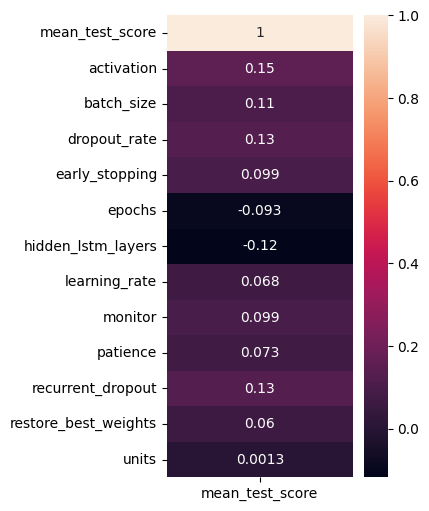

In [48]:
plt.figure(figsize=(3,6))
sns.heatmap(pd.DataFrame(df_cv_results.corr()['mean_test_score']), annot=True);

In [49]:
# make predictions (experiment)
predictions = best_model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
test_metrics = get_metrics(y_test_inv, predictions)

4/4 [==============================] - 0s 9ms/step


In [50]:
predictions_train = best_model.predict(x_train)
predictions_train = predictions_train.reshape(-1, 1)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
train_metrics = get_metrics(y_train_inv, predictions_train)

11/11 [==============================] - 0s 10ms/step


In [51]:
# save experiment model
model_filename = f"btc_eur_mape_{str(round(test_metrics['mape'], 2))}_r2_{str(round(test_metrics['r2'], 2))}.keras"
best_model.model.save(f'models/{model_filename}')

In [52]:
# save experiment results
number_of_lstm_layers = len([layer for layer in best_model.model.layers if isinstance(layer, LSTM)])
print('TEST SET:', test_metrics)
print('TRAIN SET:', train_metrics)
print(f'Number of LSTM layers: {number_of_lstm_layers}')
with open('experiments/experiments.txt', 'a') as f:
    f.write(f'{test_metrics}\n')
    f.write(f'{train_metrics}\n')
    f.write(f'Number of LSTM layers: {number_of_lstm_layers}\n')
    best_optimizer_params = best_model.get_params() 
    for k, v in best_optimizer_params.items():
        if k in ['units', 'activation', 'dropout_rate', 'recurrent_dropout', 'epochs', 'batch_size', 'validation_split', 
                 'loss', 'learning_rate', 'early_stopping', 'monitor', 'patience', 'restore_best_weights']:
            param_info = f'{k}: {v}'
            f.write(f'{param_info}\n')
            print(param_info)
    f.write('\n')

TEST SET: {'mae': 1976.1167179687495, 'mape': 5.322668060199701, 'r2': 0.7699277309474708}
TRAIN SET: {'mae': 348.79080591517857, 'mape': 1.536818611050476, 'r2': 0.9831256659413454}
Number of LSTM layers: 2
activation: softsign
batch_size: 64
dropout_rate: 0.2
early_stopping: True
epochs: 250
learning_rate: 0.005339775740535658
loss: mean_squared_error
monitor: loss
patience: 50
recurrent_dropout: 0.0
restore_best_weights: True
units: 96
validation_split: 0.1


In [53]:
best_model_saved = load_model('models/btc_eur_best_model.keras')

In [54]:
# make predictions (best_model)
predictions = best_model_saved.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
test_metrics_saved = get_metrics(y_test_inv, predictions)

4/4 [==============================] - 0s 11ms/step


In [55]:
predictions_train = best_model_saved.predict(x_train)
predictions_train = scaler.inverse_transform(predictions_train)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
train_metrics_saved = get_metrics(y_train_inv, predictions_train)

11/11 [==============================] - 0s 12ms/step


In [56]:
print('TEST SET:', test_metrics_saved)
print('TRAIN SET:', train_metrics_saved)

TEST SET: {'mae': 731.3282742187502, 'mape': 2.034328514549924, 'r2': 0.9598901850702929}
TRAIN SET: {'mae': 424.5643697544643, 'mape': 1.8918092636330102, 'r2': 0.9788580930832652}


In [57]:
# if the experiment result is better than the existing best model, save it as the (new) best model
if test_metrics['mape'] < test_metrics_saved['mape'] and test_metrics['r2'] > test_metrics_saved['r2']:
    best_model.model.save('models/btc_eur_best_model.keras')
    print("New best model saved")

In [58]:
best_model_saved = load_model('models/btc_eur_best_model.keras')

In [59]:
# make forecast (best_model)
future_steps = 30
forecast = []
input_data = x_test[-1]

for _ in range(future_steps):
    input_data = input_data.reshape((1, 50, 1))
    prediction = best_model_saved.predict(input_data)
    forecast.append(prediction[0])
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

forecast_inversed = scaler.inverse_transform(np.array(forecast).reshape((future_steps, 1)))

1/1 [==============================] - 0s 18ms/step


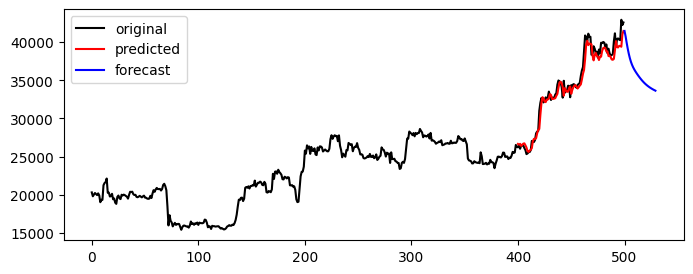

In [60]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(df, color='black', label='original')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)), predictions, color='red', label='predicted')
plt.plot(range(len(df), len(df)+future_steps), forecast_inversed, color='blue', label='forecast')
plt.legend();

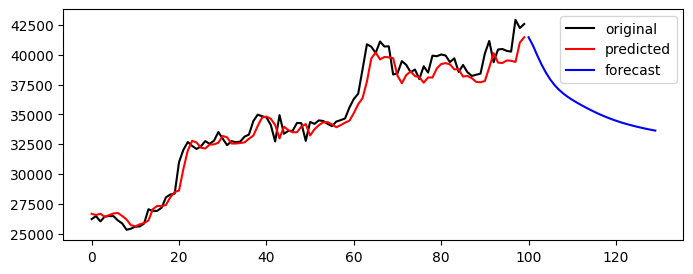

In [61]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(y_test_inv, color='black', label = 'original')
plt.plot(predictions, color = 'red', label='predicted')
plt.plot(range(100, 100+future_steps), forecast_inversed, color='blue', label='forecast')
plt.legend();

In [62]:
# below presentation is valid only for the newly fetched data; 
# otherwise dates and BTC/EUR values are not alligned since the last value from the dataset is treated as today's value
today = datetime.today()
next_day = today + timedelta(days=1)
one_week = today + timedelta(days=7)
one_month = today + timedelta(days=30)
today_value = df[-1][0]
next_day_forcasted_value = forecast_inversed[0][0]
one_week_forcasted_value = forecast_inversed[6][0]
one_month_forcasted_value = forecast_inversed[29][0]
change_value = np.abs(today_value - next_day_forcasted_value)
change_description = '-' if today_value > next_day_forcasted_value else '+'
message = f"""
BTC/EUR

TODAY      ({today.date()}): {today_value} EUR

FORECASTED ({next_day.date()}): {next_day_forcasted_value:.2f} EUR ({change_description}{change_value:.2f})
           ({one_week.date()}): {one_week_forcasted_value:.2f} EUR
           ({one_month.date()}): {one_month_forcasted_value:.2f} EUR
"""
print(message)


BTC/EUR

TODAY      (2024-01-13): 42593.8 EUR

FORECASTED (2024-01-14): 41478.06 EUR (-1115.74)
           (2024-01-20): 37441.98 EUR
           (2024-02-12): 33642.03 EUR

